In [1]:
import math
import numpy as np
import dataclasses
import matplotlib.pyplot as plt
from typing import Tuple, Iterable
from pycpd import RigidRegistration

In [2]:
# Map parameters and robot scanning parameters
MAP_SIZE = 80
LIDAR_ANGLE_STEP = 3
LIDAR_ANGLE_RANGE = 360
LIDAR_MAX_DISTANCE = 35
OCCUPANCY_GRID_X_SHIFT = MAP_SIZE
OCCUPANCY_GRID_Y_SHIFT = MAP_SIZE

In [3]:
@dataclasses.dataclass
class RobotState:
    x: float
    y: float
    theta: float

@dataclasses.dataclass
class Room:
    map_as_2d_array: np.ndarray
    map_size: int
    obstacle_positions: Iterable[Tuple[float, float]]

@dataclasses.dataclass
class Transformation:
    s: float
    R: np.array
    t: Tuple[float, float]

@dataclasses.dataclass
class RoomTestSetup:
    obstacle_positions: Iterable[Tuple[float, float]]
    robot_positions: Iterable[RobotState]

In [4]:
def paint_square(x0: int, y0: int, x1: int, y1: int):
    obstacles = []
    for i in range(x1-x0):
        for j in range(y1-y0):
            obstacles.append((x0+i,y0+j))
    return obstacles

def fill_straight_line(x0: int, y0: int, x1: int, y1: int):
    obstacles = []
    if y0 == y1:
        for i in range(x1-x0):
            obstacles.append((x0+i,y0))
    elif x0 == x1:
        for j in range(y1-y0):
            obstacles.append((x0, y0+j))
    else:
        raise Exception("the line must be straight")
    return obstacles

# Placement of objects on the map and the robot
obstacle_positions1 = [
    *paint_square(1, 50, 20, 69),
    *paint_square(30, 50, 40, 69),
    *paint_square(50, 50, 69, 69),
    *paint_square(60, 20, 69, 50),
    *paint_square(50, 1, 69, 20),
    *paint_square(30, 30, 40, 40),
    *paint_square(30, 1, 40, 20),
    *paint_square(1, 1, 20, 20),
    *paint_square(1, 20, 10, 50)
]

obstacle_positions1 = list(set(obstacle_positions1))

obstacle_positions2 = [

    *paint_square(10, 60, 40, 69),
    *paint_square(10, 40, 40, 50),
    *paint_square(10, 1, 20, 20),
    *paint_square(1, 1, 10, 69),
    *paint_square(30, 10, 40, 20),
    *paint_square(50, 1, 69, 69),
    *paint_square(10, 30, 20, 40)
]

# 1 room
room_test_1 = RoomTestSetup(
    obstacle_positions=obstacle_positions1,
    robot_positions=[
        RobotState(x=45,y=5,theta=math.radians(0)),
        RobotState(x=45,y=10,theta=math.radians(0)),
        RobotState(x=45,y=15,theta=math.radians(0)),
        RobotState(x=45,y=20,theta=math.radians(0)),
        RobotState(x=45,y=25,theta=math.radians(0)),
        RobotState(x=40,y=25,theta=math.radians(0)),
        RobotState(x=35,y=25,theta=math.radians(0)),
        RobotState(x=30,y=25,theta=math.radians(0)),
        RobotState(x=25,y=25,theta=math.radians(0)),
        RobotState(x=25,y=30,theta=math.radians(0)),
        RobotState(x=25,y=35,theta=math.radians(0)),
        RobotState(x=25,y=40,theta=math.radians(0)),
        RobotState(x=25,y=45,theta=math.radians(0)),
        RobotState(x=30,y=45,theta=math.radians(0)),
        RobotState(x=35,y=45,theta=math.radians(0)),
        RobotState(x=40,y=45,theta=math.radians(0)),
        RobotState(x=45,y=45,theta=math.radians(0)),
        RobotState(x=40,y=50,theta=math.radians(0)),
        RobotState(x=45,y=55,theta=math.radians(0)),
        RobotState(x=45,y=25,theta=math.radians(0))
    ]
) 

# 2 room
room_test_2 = RoomTestSetup(
    obstacle_positions=obstacle_positions2,
    robot_positions=[
        RobotState(x=25,y=5,theta=math.radians(0)),
        RobotState(x=25,y=9,theta=math.radians(0)),
        RobotState(x=25,y=13,theta=math.radians(0)),
        RobotState(x=25,y=17,theta=math.radians(0)),
        RobotState(x=25,y=20,theta=math.radians(0)),
        RobotState(x=24,y=24,theta=math.radians(0)),
        RobotState(x=28,y=28,theta=math.radians(0)),
        RobotState(x=32,y=32,theta=math.radians(0)),
        RobotState(x=36,y=36,theta=math.radians(0)),
        RobotState(x=40,y=36,theta=math.radians(0)),
        RobotState(x=44,y=36,theta=math.radians(0)),
        RobotState(x=44,y=40,theta=math.radians(0)),
        RobotState(x=44,y=44,theta=math.radians(0)),
        RobotState(x=44,y=48,theta=math.radians(0)),
        RobotState(x=44,y=52,theta=math.radians(0)),
        RobotState(x=44,y=56,theta=math.radians(0)),
        RobotState(x=40,y=56,theta=math.radians(0)),
        RobotState(x=36,y=56,theta=math.radians(0)),
        RobotState(x=32,y=56,theta=math.radians(0)),
        RobotState(x=28,y=56,theta=math.radians(0)),
        RobotState(x=24,y=56,theta=math.radians(0))
    ]
)

In [5]:
from typing import Iterable, Tuple


def create_room(
    room_size: int, 
    obstacle_positions: Iterable[Tuple[int, int]],
    robot_pose: RobotState,
) -> Room:
    """Makes a room with occupied points"""
    room = np.zeros((room_size, room_size))
    for obstacle_position in obstacle_positions:
        room[obstacle_position[::-1]] = 1

    for i in range(room_size):
        room[(0, i)] = 1
        room[(i, 0)] = 1
        room[(i, room_size - 1)] = 1
        room[(room_size - 1, i)] = 1
    # 0.5 defines the robot
    room[(robot_pose.x, robot_pose.y)[::-1]] = 0.5
    
    return Room(map_as_2d_array=room, map_size=room_size, obstacle_positions=obstacle_positions)

def perform_radar_measurement(pos: RobotState, room, step=LIDAR_ANGLE_STEP, max_distance=LIDAR_MAX_DISTANCE) -> (np.ndarray, np.ndarray):
    """
    The function performs laser scanning (aka LIDAR)
    Returns scanned distances (-1 - further than max. distance) and angles
    """
    degress_start = math.degrees(pos.theta)
    degress_start = round(degress_start) 
    angles = np.arange(degress_start, degress_start + LIDAR_ANGLE_RANGE, step) % 360
    scan_distances = []

    for angle in angles:
        rad = np.radians(angle)
        distance = -1  # -1 if no obstacle detected
        for r in range(1, max_distance):
            x = round(pos.x + r * np.cos(rad))
            y = round(pos.y + r * np.sin(rad))

            # walls and obstacles
            if x < 0 or y < 0 or x >= MAP_SIZE or y >= MAP_SIZE or room[y, x] == 1:
                distance = r
                break

        scan_distances.append(distance)

    return np.array(scan_distances), angles

def visualize_scan_result(pose: RobotState, scan_distances, angles, room, obstacle_positions) -> None:
    """Visualizes map, robot, obstacles and scan results"""
    plt.figure(figsize=(6, 6))
    plt.imshow(room, cmap='Greys', origin='lower')
    plt.scatter(*zip(*obstacle_positions), color='g', label='Walls')
    plt.scatter(pose.x, pose.y, color='blue', label='Robot', s=100)
    
    angles = np.radians(angles)

    # Draw lines for each scan beam released
    for i, (angle, distance) in enumerate(zip(angles, scan_distances)):
        if distance != -1:
            end_point = (pose.x + distance * np.cos(angle), pose.y + distance * np.sin(angle))
            color = 'orange' if i == 0 else 'red'
            linewidth = 2.0 if i == 0 else 0.5
            plt.plot([pose.x, end_point[0]], [pose.y, end_point[1]], color=color, linewidth=linewidth)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Map with robot and scan result')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()

def convert_scan_data_to_coordinates(scan_distances, angles):
    """
    Converts scan distances to a point cloud
    The robot is at point (0, 0) with an angle of 0 radians
    """
    angles_rad = np.radians(np.arange(0, LIDAR_ANGLE_RANGE, LIDAR_ANGLE_STEP))
    
    valid_distances = scan_distances[scan_distances > 0]
    valid_angles_rad = angles_rad[scan_distances > 0]

    x_coords = valid_distances * np.cos(valid_angles_rad)
    y_coords = valid_distances * np.sin(valid_angles_rad)
    
    return np.column_stack((x_coords, y_coords))

def display_point_sets(A, B, transformed_A=None):
    """
    Represents two point clouds on one plot
    """
    plt.figure(figsize=(6, 6))

    plt.scatter(A[:, 0], A[:, 1], color='red', marker='x', label='Point cloud 1')

    plt.scatter(B[:, 0], B[:, 1], color='blue', marker='o', label='Point cloud 2')

    if transformed_A is not None:
        plt.scatter(transformed_A[:, 0], transformed_A[:, 1], color='blue', marker='o', label='Transformed point cloud 1')
    
    plt.title("Visualization of point clouds")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.axis('equal')
    plt.show()

def compute_point_cloud_transformation(point_cloud1, point_cloud2) -> [np.array, Transformation]:
    """
    We define the transformation between two point clouds using CPD
    Returning the transformed cloud and transformation parameters
    """
    reg = RigidRegistration(X=point_cloud2, Y=point_cloud1)
    TY, (s_reg, R_reg, t_reg) = reg.register()
    return reg.transform_point_cloud(Y=point_cloud1), Transformation(s=s_reg, R=R_reg, t=t_reg)

def get_x_y_theta_diff_by_transformation(transformation: Transformation) -> Tuple[float, float, float]:
    cos_theta = np.round(transformation.R[0,0], 5)
    if transformation.R[0,1] < 0:
        estimated_theta_sign = 1
    elif transformation.R[1,0] <= 0:
        estimated_theta_sign = -1

    cpd_estimated_theta = math.acos(cos_theta)
    cpd_estimated_theta *= estimated_theta_sign
    cpd_estimated_x = -transformation.t[0]
    cpd_estimated_y = -transformation.t[1]

    return cpd_estimated_x, cpd_estimated_y, cpd_estimated_theta

def display_scan_results(pose1: RobotState, pose2: RobotState, transformation: Transformation) -> None:    
    ROUND_DECIMALS = 3

    cos_theta = np.round(transformation.R[0,0], 5)
    if transformation.R[0,1] < 0:
        estimated_theta_sign = 1
    elif transformation.R[1,0] <= 0:
        estimated_theta_sign = -1

    cpd_estimated_theta = math.acos(cos_theta)
    cpd_estimated_theta *= estimated_theta_sign
    cpd_estimated_x = -transformation.t[0]
    cpd_estimated_y = -transformation.t[1]

    # True Transformation
    actual_x_translation = pose2.x - pose1.x
    actual_y_translation = pose2.y - pose1.y
    actual_theta_translation = pose2.theta - pose1.theta

    # Transformation difference
    diff_x = actual_x_translation - cpd_estimated_x
    diff_y = actual_y_translation - cpd_estimated_y
    diff_theta = actual_theta_translation - cpd_estimated_theta

    # Round to avoid looking at 20 decimal places
    cpd_estimated_theta = np.round(cpd_estimated_theta, ROUND_DECIMALS)
    cpd_estimated_x = np.round(cpd_estimated_x, ROUND_DECIMALS)
    cpd_estimated_y = np.round(cpd_estimated_y, ROUND_DECIMALS)
    actual_x_translation = np.round(actual_x_translation, ROUND_DECIMALS)
    actual_y_translation = np.round(actual_y_translation, ROUND_DECIMALS)
    actual_theta_translation = np.round(actual_theta_translation, ROUND_DECIMALS)
    diff_x = np.round(abs(diff_x), ROUND_DECIMALS)
    diff_y = np.round(abs(diff_y), ROUND_DECIMALS)
    diff_theta = np.round(abs(diff_theta), ROUND_DECIMALS)

    diff_x_from_room = np.round(diff_x / MAP_SIZE * 100, ROUND_DECIMALS)
    diff_y_from_room = np.round(diff_y / MAP_SIZE * 100, ROUND_DECIMALS)
    diff_theta_from_2pi = np.round(diff_theta / math.radians(360) * 100, ROUND_DECIMALS)

    translation_vector_length = round(
        math.sqrt((diff_x)**2 + (diff_y)**2)
        , 3
    )
    room_diagonal_length = MAP_SIZE * math.sqrt(2)
    translation_vector_accuracy = round(translation_vector_length / room_diagonal_length * 100, 3)

    print(f"{MAP_SIZE=} {LIDAR_ANGLE_STEP=} {pose1=} {pose2=}")
    print(f"Accuracy of X/Y vector transformation - {translation_vector_accuracy}%")

    print("True Transformation")
    print(f"\tX\t{actual_x_translation}")
    print(f"\tY\t{actual_y_translation}")
    print(f"\tθ(rad)\t{actual_theta_translation}")

    print("Calculated Transformation")
    print(f"\tX\t{cpd_estimated_x}")
    print(f"\tY\t{cpd_estimated_y}")
    print(f"\tθ(rad)\t{cpd_estimated_theta}")

    print("Differences in Transformations (% of room size)")
    print(f"\tX\t{diff_x} ({diff_x_from_room}%)")
    print(f"\tY\t{diff_y} ({diff_y_from_room}%)")
    print(f"\tθ(rad)\t{diff_theta} ({diff_theta_from_2pi}%) (% of 2*Pi)")

In [6]:
def bresenham_line(x0, y0, x1, y1):
    """
    Bresenham's Line Algorithm
    """
    x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))  # Make sure to include the end point

    return points

In [7]:
def update_occupancy_grid(grid: np.array, robot_pos: RobotState, scan_distances, angles, max_distance):
    robot_pose_corrected = RobotState(x=robot_pos.x + OCCUPANCY_GRID_X_SHIFT, y=robot_pos.y + OCCUPANCY_GRID_Y_SHIFT, theta=robot_pos.theta)
    robot_pose_corrected.x = round(robot_pose_corrected.x)
    robot_pose_corrected.y = round(robot_pose_corrected.y)

    grid[robot_pose_corrected.y, robot_pose_corrected.x] = 2
    for angle, distance in zip(angles, scan_distances):
        rad = np.radians(angle)
        for r in range(1, max_distance):
            x = round(robot_pose_corrected.x + r * np.cos(rad))
            y = round(robot_pose_corrected.y + r * np.sin(rad))
            if r < distance:
                grid[y, x] = 0  # Mark as free
            elif r == distance and distance != -1:
                # if angle == 180:
                #     print(f"{robot_pos=} {angle=} {x=} {y=} set 1 tile (occupied)")
                grid[y, x] = 1
                break  # Stop at the first obstacle

def update_grid_with_new_scan(grid, old_robot_pos, new_robot_pos, new_scan_distances, new_angles, max_distance):
        # mark the old robot position as free
        old_robot_pos_x = round(old_robot_pos.x)
        old_robot_pos_y = round(old_robot_pos.y)
        grid[(old_robot_pos_x + OCCUPANCY_GRID_X_SHIFT, old_robot_pos_y + OCCUPANCY_GRID_X_SHIFT)[::-1]] = 0

        # Update the grid with the new scan data
        update_occupancy_grid(grid, new_robot_pos, new_scan_distances, new_angles, max_distance)

def create_occupancy_grid_map() -> np.array:
    return np.full((MAP_SIZE*2, MAP_SIZE*2), -1)

def visualize_occupancy_grid_map(occupancy_grid_map: np.array) -> None:
     # Visualize the occupancy grid map
    plt.figure(figsize=(8, 8))
    plt.imshow(occupancy_grid_map, cmap='viridis', origin='lower', alpha=0.5)
    # grid for debug 
    # x_ticks = np.arange(0.5, occupancy_grid_map.shape[1], 1)
    # y_ticks = np.arange(0.5, occupancy_grid_map.shape[0], 1)
    # plt.xticks(x_ticks)
    # plt.yticks(y_ticks)
    # plt.grid(color='black', linestyle='--', linewidth=0.5)
    plt.colorbar(label='-1 Unknown | 0 Free | 1 Walls | 2 Robot')


def get_map_area(map_: np.array) -> float:
    total_tiles = map_.size
    free_tiles = np.count_nonzero(map_ == 0) + np.count_nonzero(map_ == 0.5)

    print(f"Actual room area: {total_tiles=} {free_tiles=}")
    return free_tiles

def get_occupancy_grid_map_area(map_: np.array) -> float:
    free_tiles = np.count_nonzero(map_ == 0) + np.count_nonzero(map_ == 2)
    print(f"Occupancy grid map area: {free_tiles=}")
    return free_tiles

In [8]:
def start_experiment(room_test_setup: RoomTestSetup):
    current_actual_robot_pose = room_test_setup.robot_positions[0]
    room = create_room(MAP_SIZE, room_test_setup.obstacle_positions, room_test_setup.robot_positions[0])
    
    occupancy_grid_map = create_occupancy_grid_map()
    scan_distances, angles = perform_radar_measurement(current_actual_robot_pose, room.map_as_2d_array)
    visualize_scan_result(current_actual_robot_pose, scan_distances, angles, room.map_as_2d_array, room.obstacle_positions)
    
    estimated_robot_pos1 = RobotState(x=0, y=0, theta=0)
    update_occupancy_grid(occupancy_grid_map, estimated_robot_pos1, scan_distances, angles, LIDAR_MAX_DISTANCE)

    visualize_occupancy_grid_map(occupancy_grid_map)

    actual_diff_x_accum, actual_diff_y_accum, actual_diff_theta_accum = 0.0, 0.0, 0.0
    estimated_diff_x_accum, estimated_diff_y_accum, estimated_diff_theta_accum = 0.0, 0.0, 0.0

    for i, pose in enumerate(room_test_setup.robot_positions[1:], start=1):
        previous_actual_robot_pose: RobotState = room_test_setup.robot_positions[i-1]
        current_actual_robot_pose: RobotState = pose
        scan_distances2, angles2 = perform_radar_measurement(current_actual_robot_pose, room.map_as_2d_array)
        room.map_as_2d_array[(current_actual_robot_pose.x, current_actual_robot_pose.y)[::-1]] = 0.5
        visualize_scan_result(current_actual_robot_pose, scan_distances2, angles2, room.map_as_2d_array, room.obstacle_positions)

        point_cloud1 = convert_scan_data_to_coordinates(scan_distances, angles)
        point_cloud2 = convert_scan_data_to_coordinates(scan_distances2, angles2)
        point_cloud1_transformed, transformation = compute_point_cloud_transformation(point_cloud1, point_cloud2)
        # display_point_sets(point_cloud1, point_cloud2, point_cloud1_transformed)
        # display_scan_results(previous_actual_robot_pose, current_actual_robot_pose, transformation)
        estimated_diff_x, estimated_diff_y, estimated_diff_theta = get_x_y_theta_diff_by_transformation(transformation)
        acutal_diff_x, acutal_diff_y, actual_diff_theta = current_actual_robot_pose.x - previous_actual_robot_pose.x, current_actual_robot_pose.y - previous_actual_robot_pose.y, current_actual_robot_pose.theta - previous_actual_robot_pose.theta,
        actual_diff_x_accum += acutal_diff_x
        actual_diff_y_accum += acutal_diff_y
        actual_diff_theta_accum += actual_diff_theta
        estimated_diff_x_accum += estimated_diff_x
        estimated_diff_y_accum += estimated_diff_y
        estimated_diff_theta_accum += estimated_diff_theta

        estimated_robot_pos2 = RobotState(
            x=estimated_robot_pos1.x+estimated_diff_x,
            y=estimated_robot_pos1.y+estimated_diff_y,
            theta=estimated_robot_pos1.theta+estimated_diff_theta
        )
        
        print(f"{actual_diff_x_accum=}\n{actual_diff_y_accum=}\n{actual_diff_theta_accum=}\n")
        print(f"{estimated_diff_x_accum=}\n{estimated_diff_y_accum=}\n{estimated_diff_theta_accum=}\n")
        
        update_grid_with_new_scan(occupancy_grid_map, estimated_robot_pos1, estimated_robot_pos2, scan_distances2, angles2, LIDAR_MAX_DISTANCE)
        visualize_occupancy_grid_map(occupancy_grid_map)
        
        scan_distances, angles = scan_distances2, angles2
        estimated_robot_pos1 = estimated_robot_pos2

        actual_room_area = get_map_area(room.map_as_2d_array)
        occupancy_grid_map_area = get_occupancy_grid_map_area(occupancy_grid_map)
        
        area_diff_percent = abs((actual_room_area - occupancy_grid_map_area) / actual_room_area * 100)

        print(f"{i=} Grid and Map area diff: {area_diff_percent:.2f}%")

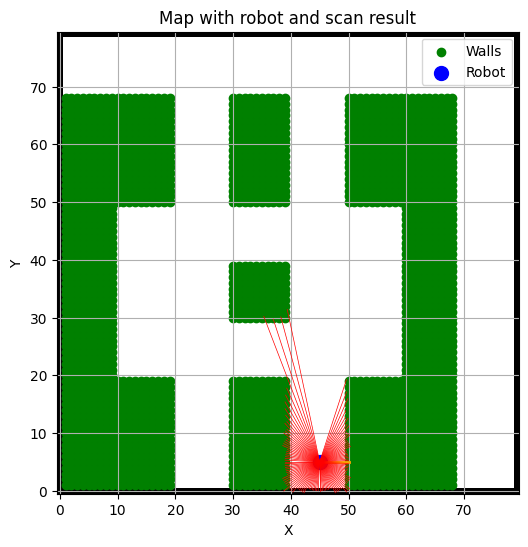

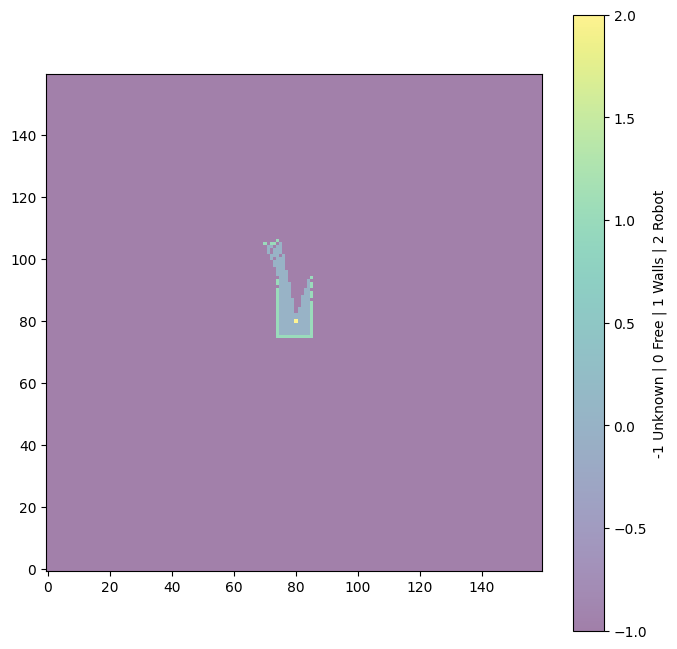

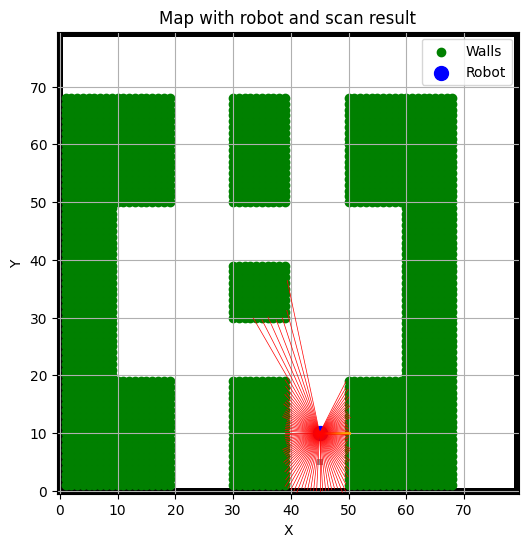

actual_diff_x_accum=0.0
actual_diff_y_accum=5.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-0.05553508501067328
estimated_diff_y_accum=4.681856184943079
estimated_diff_theta_accum=-0.008944301724511662

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=236
i=1 Grid and Map area diff: 93.48%


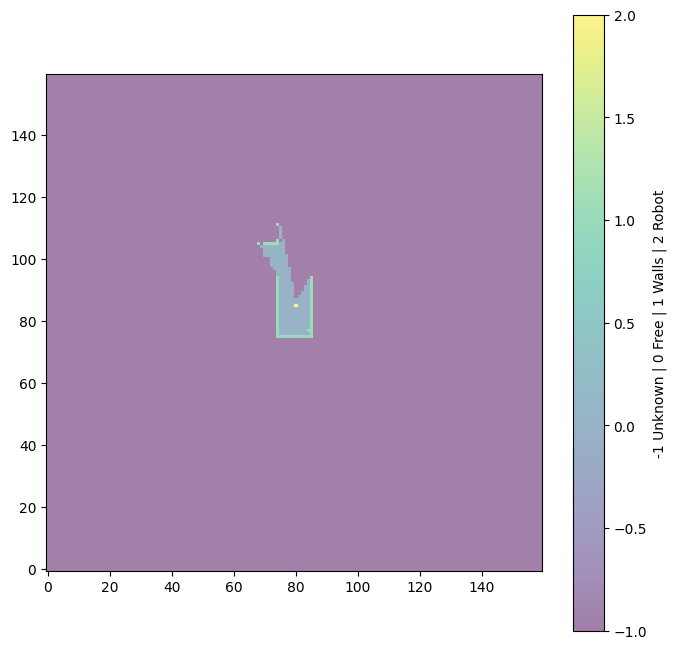

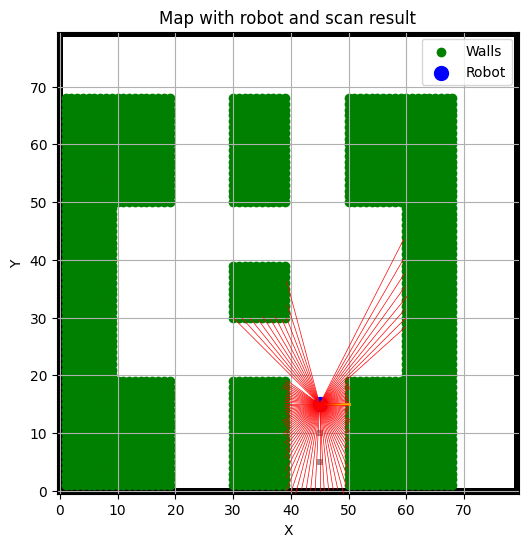

actual_diff_x_accum=0.0
actual_diff_y_accum=10.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-0.4010322037089445
estimated_diff_y_accum=5.230454452792883
estimated_diff_theta_accum=0.7519784482471947

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=417
i=2 Grid and Map area diff: 88.48%


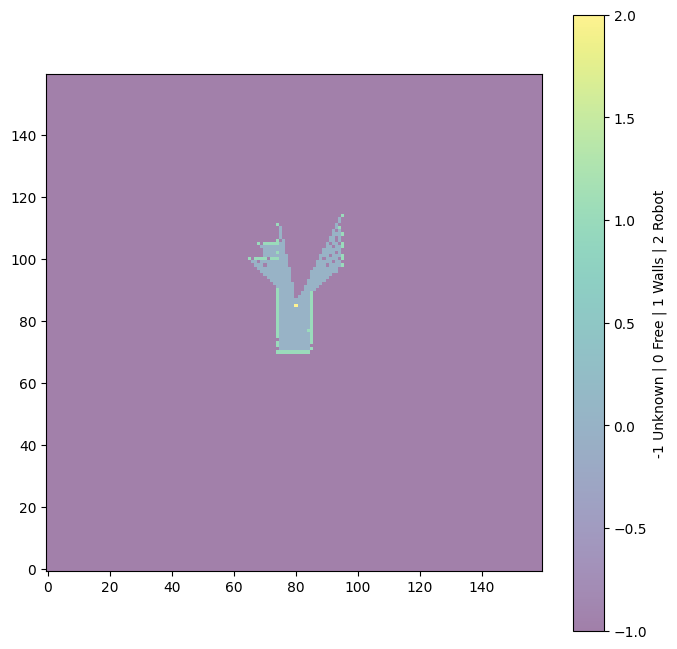

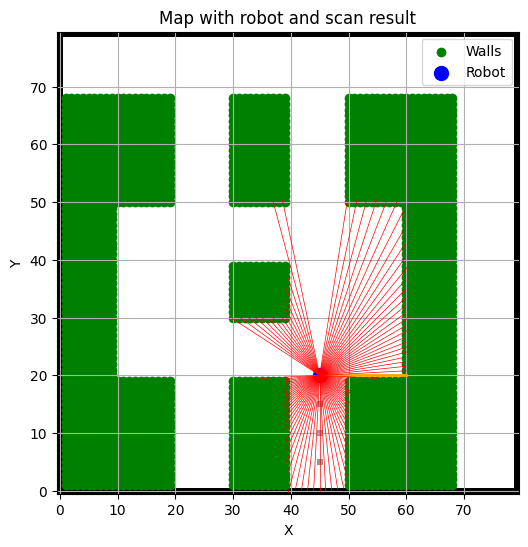

actual_diff_x_accum=0.0
actual_diff_y_accum=15.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-1.0780269749614306
estimated_diff_y_accum=8.435539152068834
estimated_diff_theta_accum=0.6718320968446492

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=708
i=3 Grid and Map area diff: 80.44%


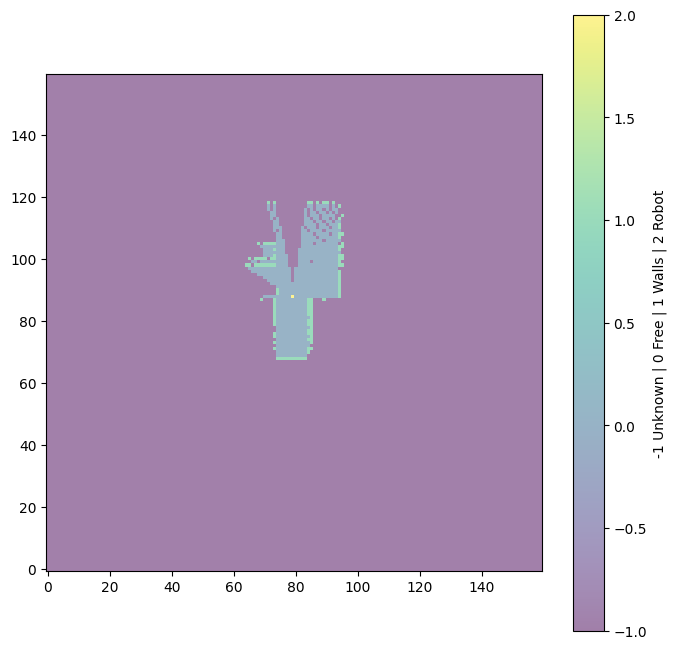

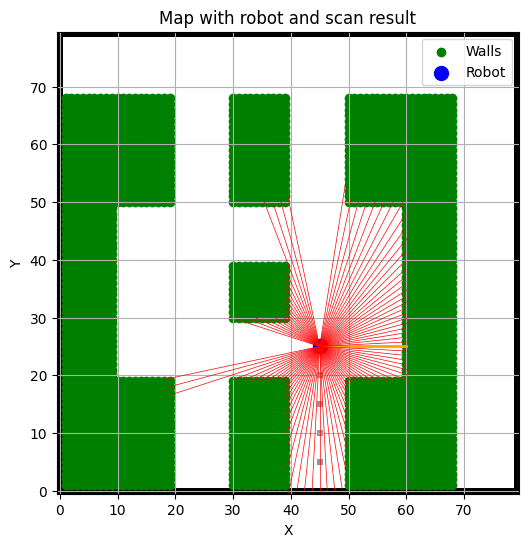

actual_diff_x_accum=0.0
actual_diff_y_accum=20.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-0.37520313369488134
estimated_diff_y_accum=13.641783854844366
estimated_diff_theta_accum=0.6628877951201375

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=865
i=4 Grid and Map area diff: 76.10%


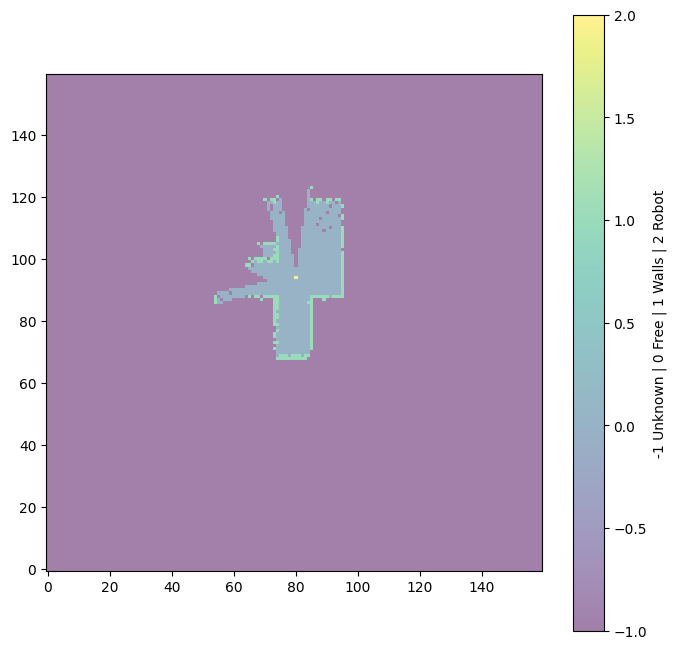

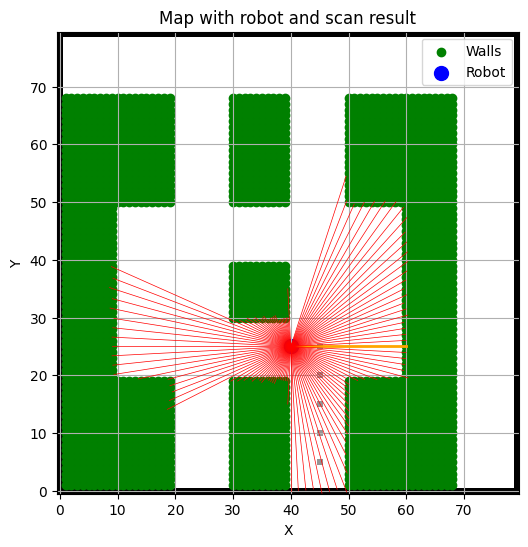

actual_diff_x_accum=-5.0
actual_diff_y_accum=20.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-3.4380117537609203
estimated_diff_y_accum=13.3816035682329
estimated_diff_theta_accum=0.8154167114826139

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=1231
i=5 Grid and Map area diff: 65.99%


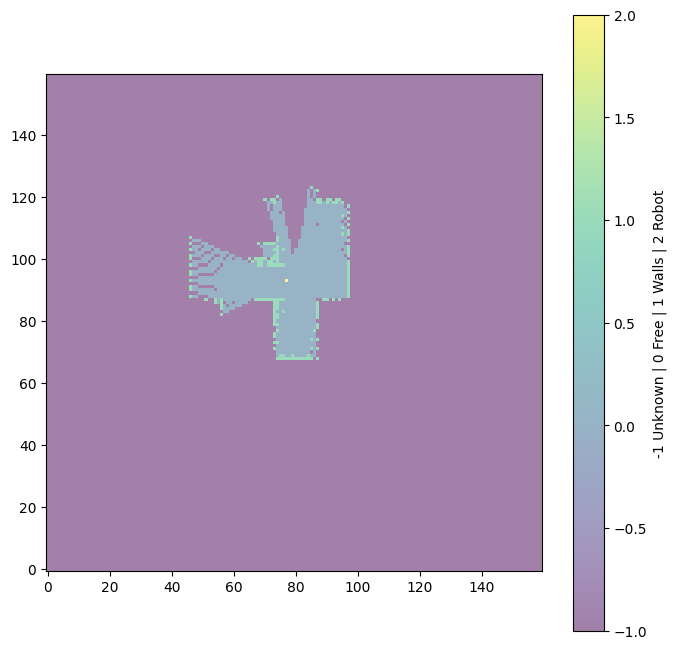

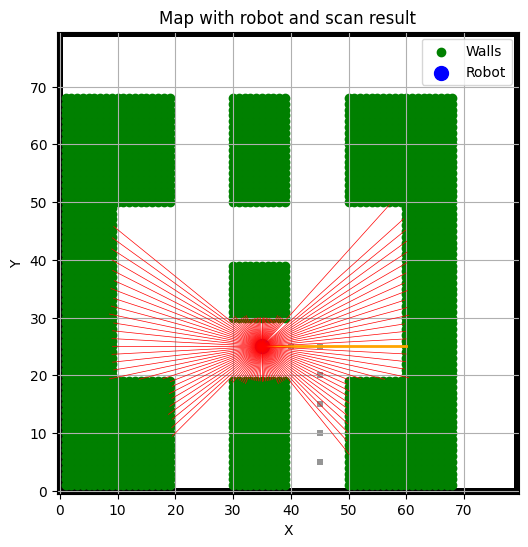

actual_diff_x_accum=-10.0
actual_diff_y_accum=20.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-8.355978539359667
estimated_diff_y_accum=13.392815815743248
estimated_diff_theta_accum=0.8288332199727119

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=1357
i=6 Grid and Map area diff: 62.51%


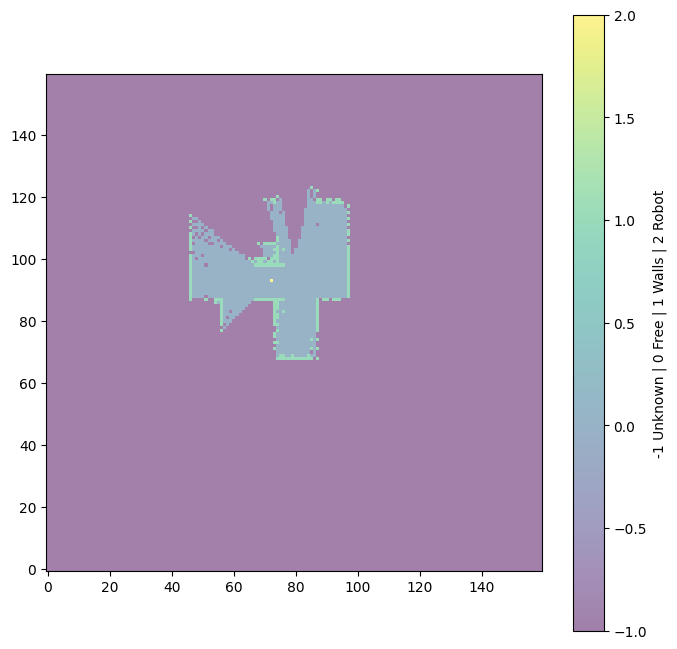

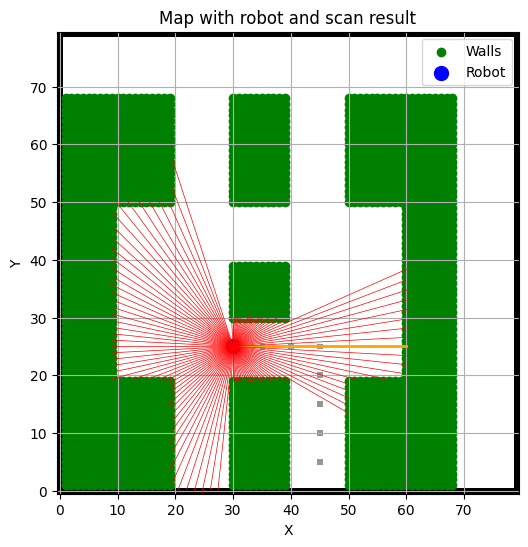

actual_diff_x_accum=-15.0
actual_diff_y_accum=20.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-6.690205882778207
estimated_diff_y_accum=15.186855589565443
estimated_diff_theta_accum=1.4427811421929002

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=1780
i=7 Grid and Map area diff: 50.83%


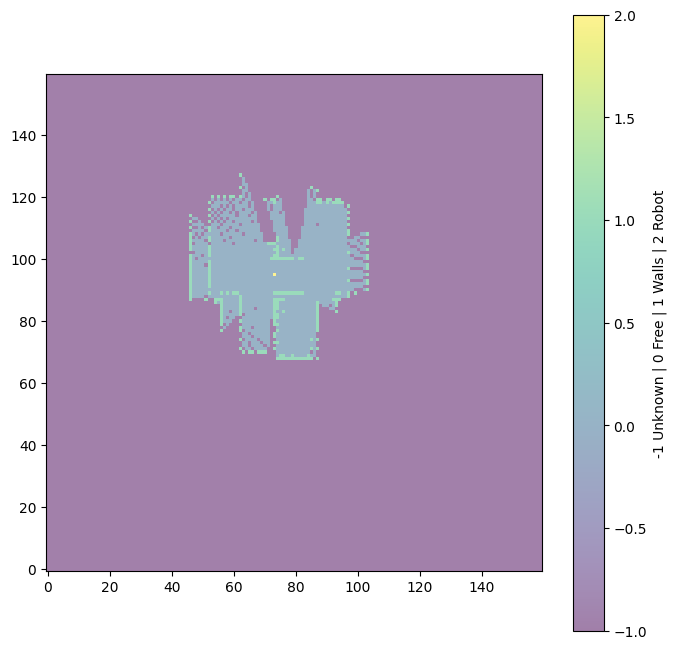

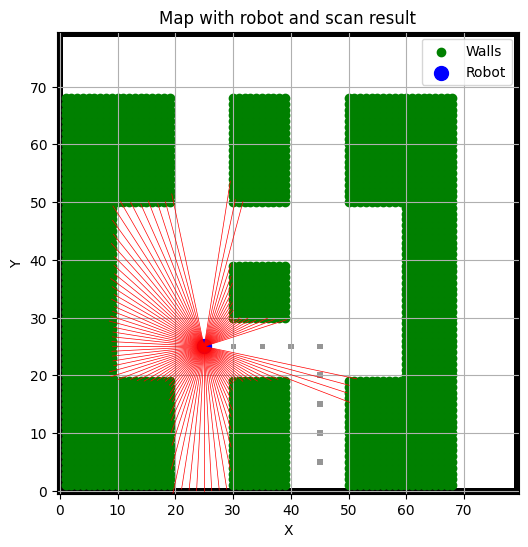

actual_diff_x_accum=-20.0
actual_diff_y_accum=20.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-11.661084177785645
estimated_diff_y_accum=15.030213443904364
estimated_diff_theta_accum=1.4825329733100963

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=1856
i=8 Grid and Map area diff: 48.73%


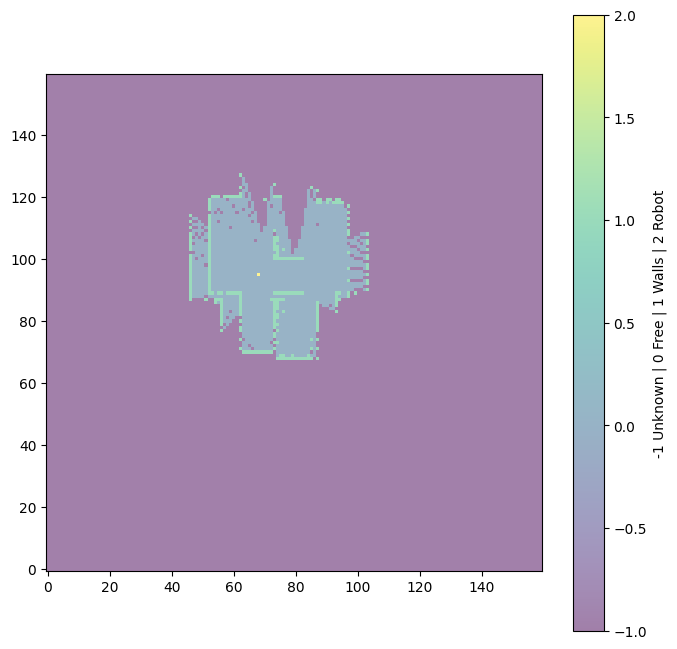

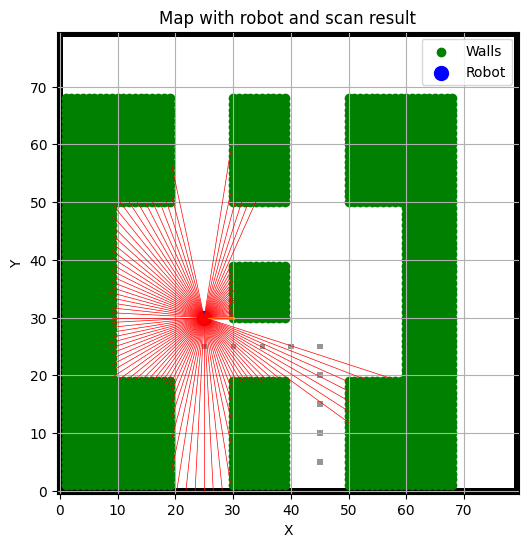

actual_diff_x_accum=-20.0
actual_diff_y_accum=25.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-11.808836624698177
estimated_diff_y_accum=19.838845427109995
estimated_diff_theta_accum=1.4902789593675552

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=1897
i=9 Grid and Map area diff: 47.60%


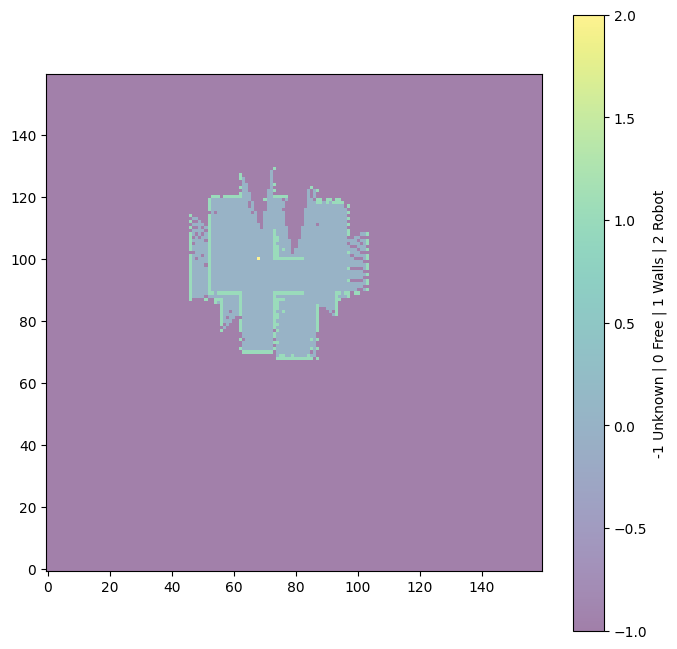

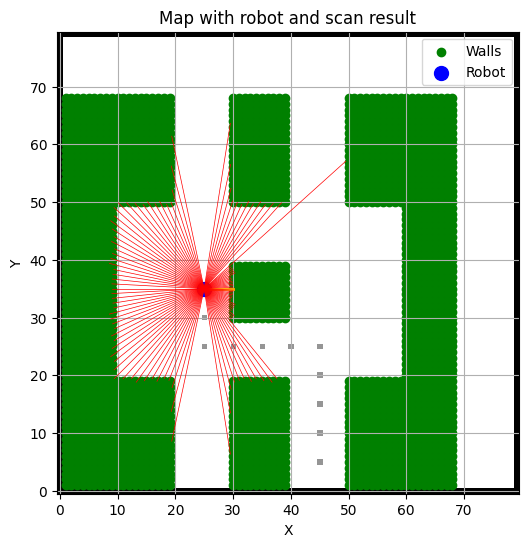

actual_diff_x_accum=-20.0
actual_diff_y_accum=30.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-12.11615771939925
estimated_diff_y_accum=24.4694689362927
estimated_diff_theta_accum=1.5163565078878325

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=1940
i=10 Grid and Map area diff: 46.41%


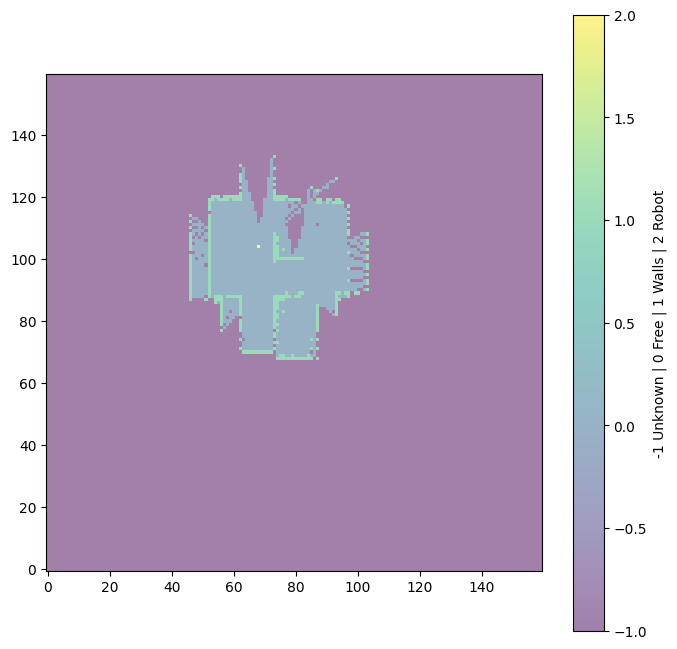

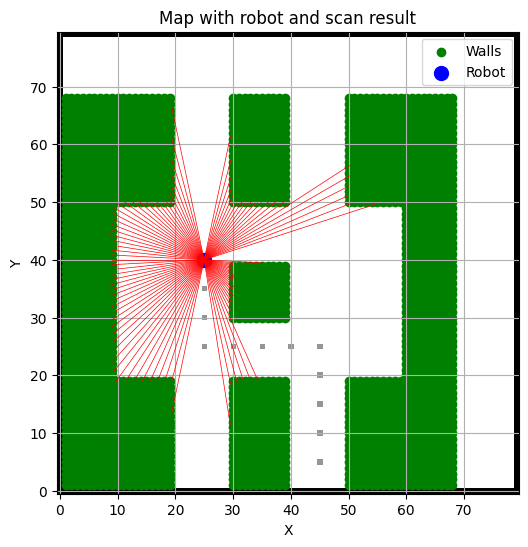

actual_diff_x_accum=-20.0
actual_diff_y_accum=35.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-11.968303454753269
estimated_diff_y_accum=29.572949350343855
estimated_diff_theta_accum=1.5711356124820535

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2022
i=11 Grid and Map area diff: 44.14%


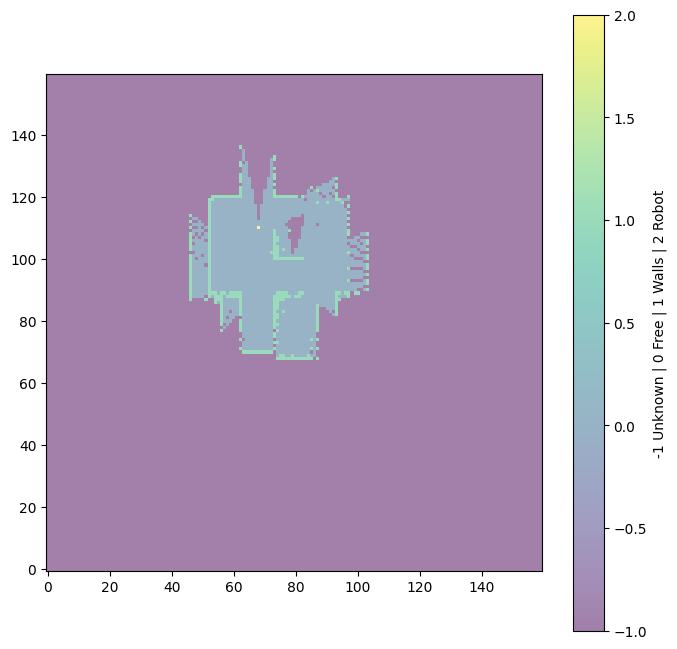

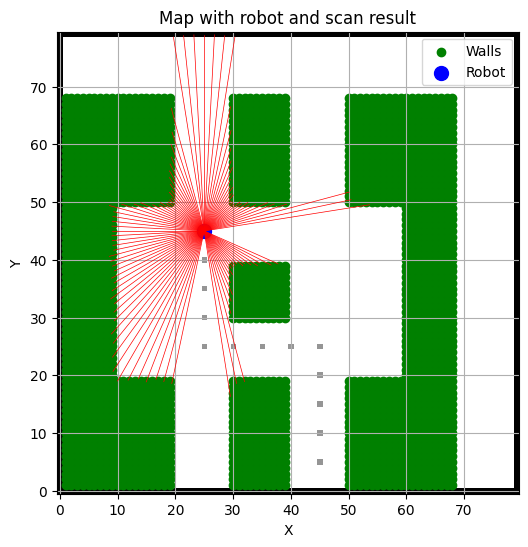

actual_diff_x_accum=-20.0
actual_diff_y_accum=40.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-12.866359402920308
estimated_diff_y_accum=32.781252272681165
estimated_diff_theta_accum=1.646519235181614

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2214
i=12 Grid and Map area diff: 38.84%


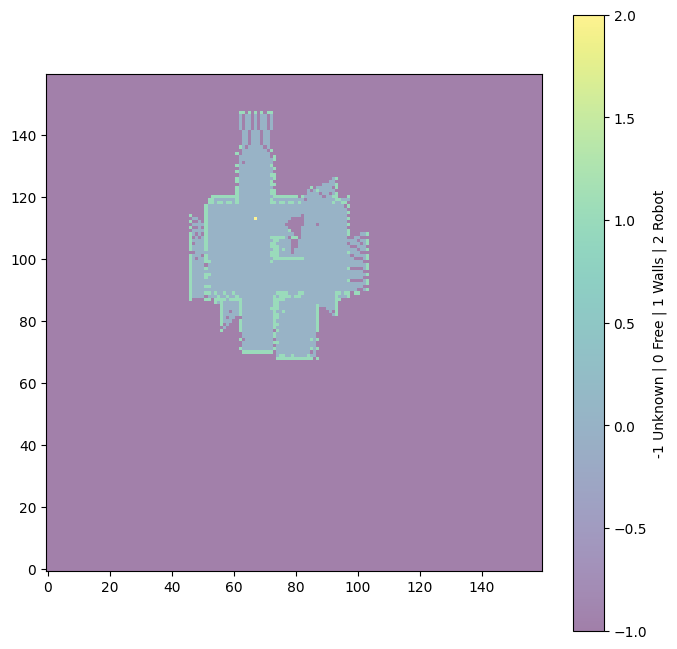

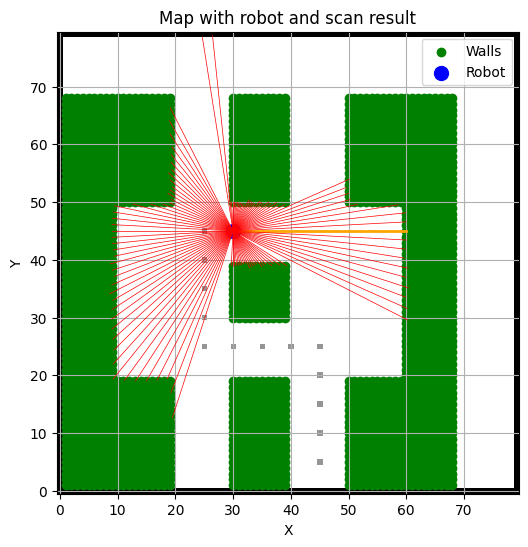

actual_diff_x_accum=-15.0
actual_diff_y_accum=40.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-11.338008668392215
estimated_diff_y_accum=37.745579183908625
estimated_diff_theta_accum=3.04523758985528

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2438
i=13 Grid and Map area diff: 32.65%


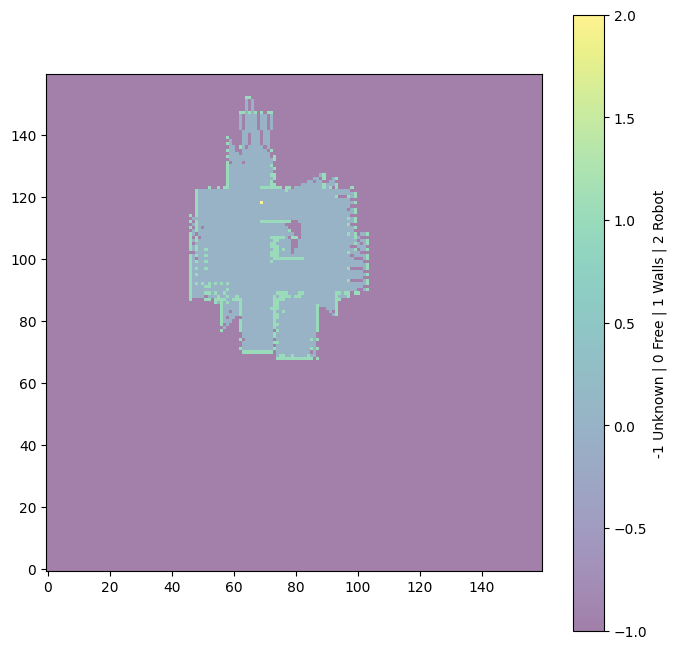

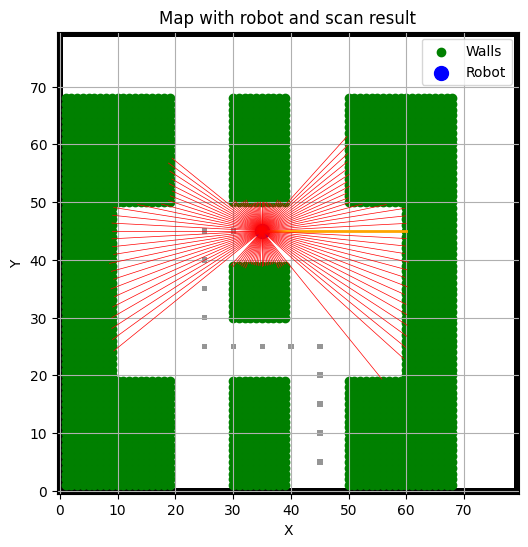

actual_diff_x_accum=-10.0
actual_diff_y_accum=40.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-6.446084356920826
estimated_diff_y_accum=37.55935967739506
estimated_diff_theta_accum=3.0728065604238655

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2503
i=14 Grid and Map area diff: 30.86%


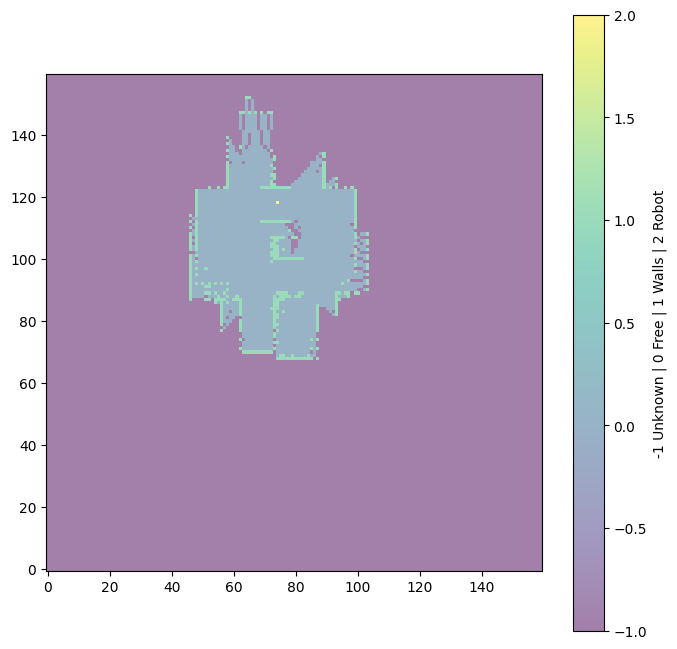

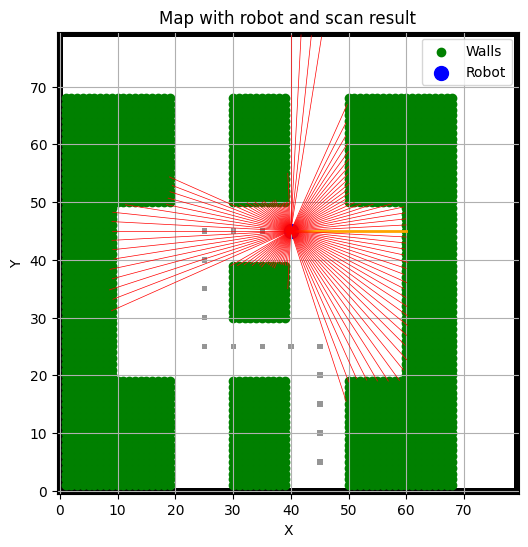

actual_diff_x_accum=-5.0
actual_diff_y_accum=40.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-7.0103352783133355
estimated_diff_y_accum=35.34942034571588
estimated_diff_theta_accum=3.52091097135923

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2684
i=15 Grid and Map area diff: 25.86%


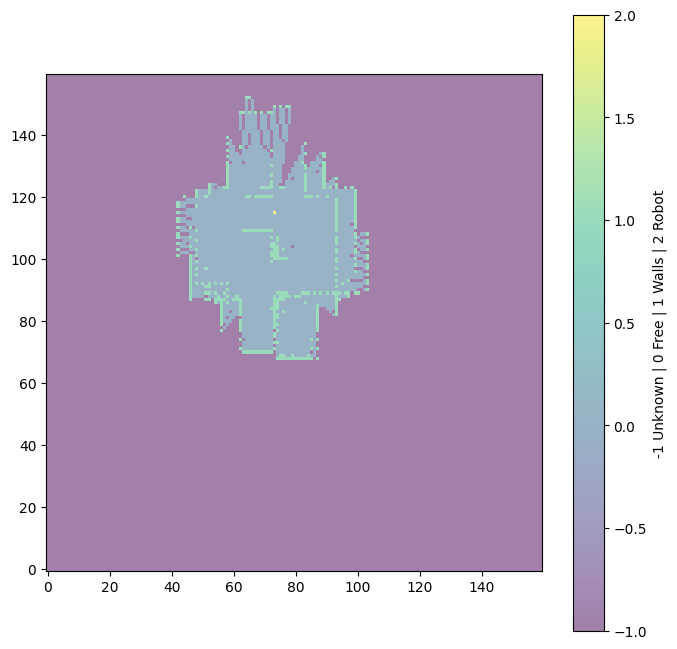

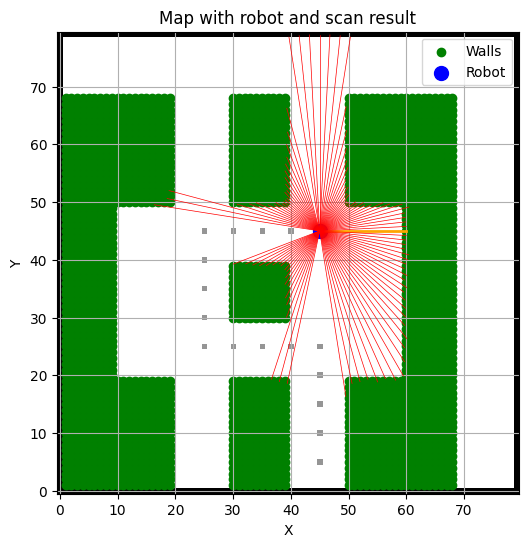

actual_diff_x_accum=0.0
actual_diff_y_accum=40.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-1.68946793341805
estimated_diff_y_accum=34.86900539210806
estimated_diff_theta_accum=3.5956277474686797

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2772
i=16 Grid and Map area diff: 23.43%


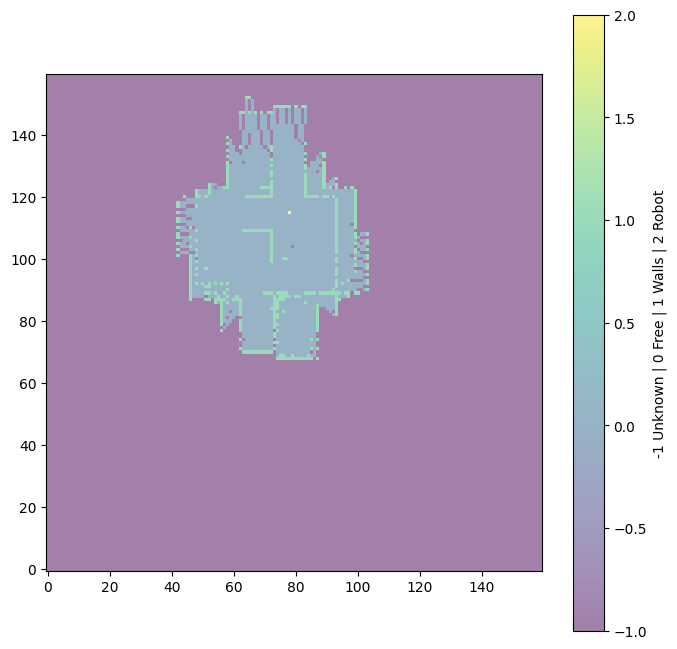

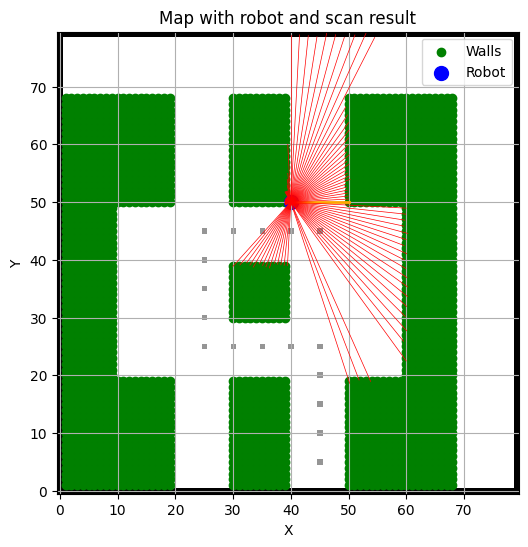

actual_diff_x_accum=-5.0
actual_diff_y_accum=45.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-6.7943757730124466
estimated_diff_y_accum=39.98863952357814
estimated_diff_theta_accum=3.619711518674649

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2811
i=17 Grid and Map area diff: 22.35%


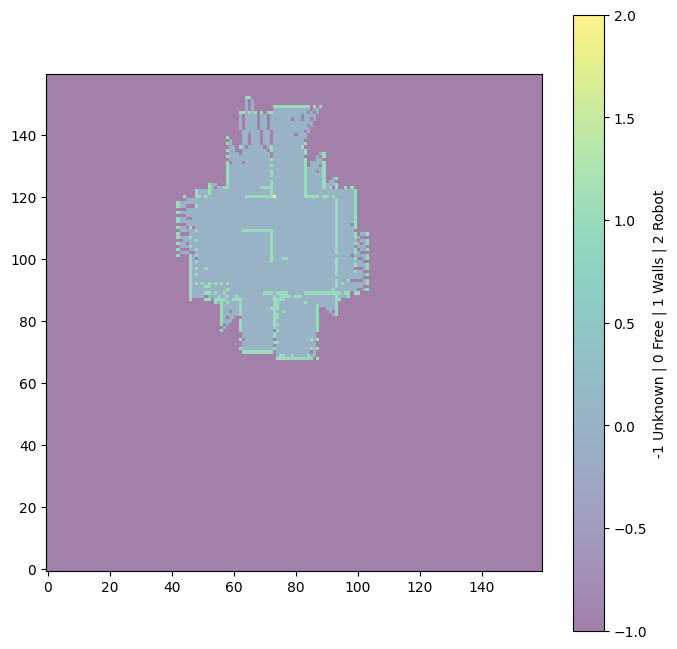

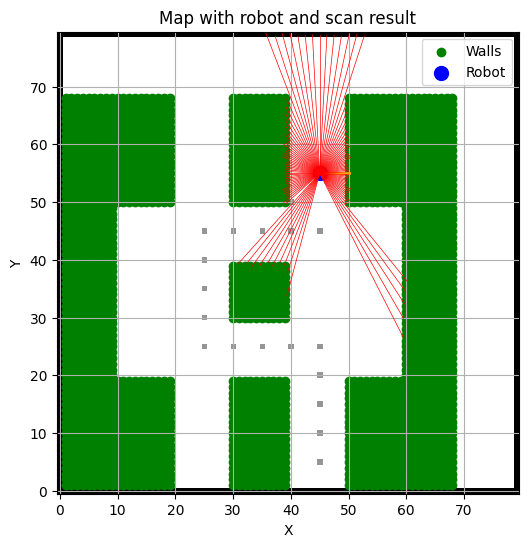

actual_diff_x_accum=0.0
actual_diff_y_accum=50.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-1.7366861847677892
estimated_diff_y_accum=43.62358219838629
estimated_diff_theta_accum=3.596046647340017

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2812
i=18 Grid and Map area diff: 22.32%


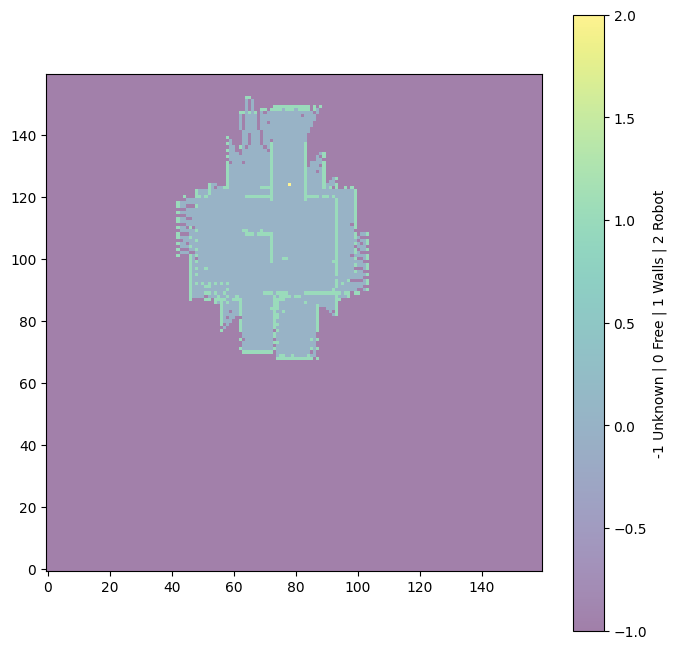

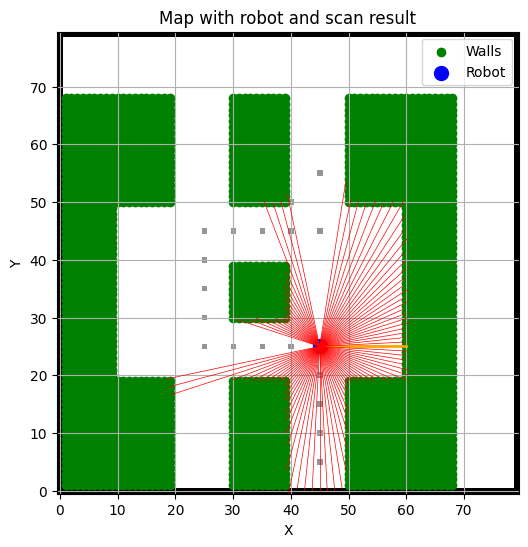

actual_diff_x_accum=0.0
actual_diff_y_accum=20.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=-2.8783705858712816
estimated_diff_y_accum=45.28622685967295
estimated_diff_theta_accum=4.050343073531609

Actual room area: total_tiles=6400 free_tiles=3620
Occupancy grid map area: free_tiles=2970
i=19 Grid and Map area diff: 17.96%


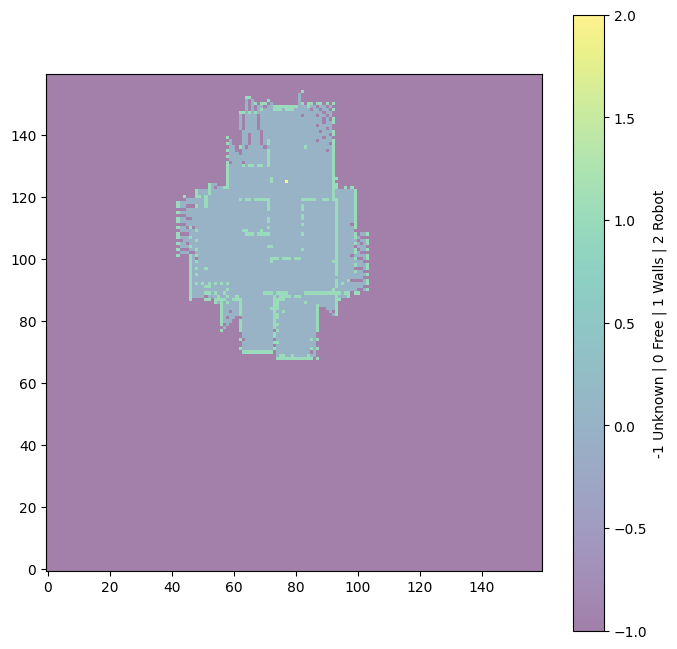

In [9]:
start_experiment(room_test_1)

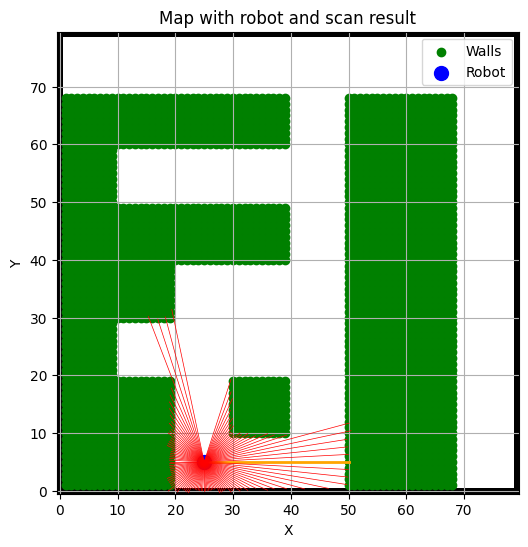

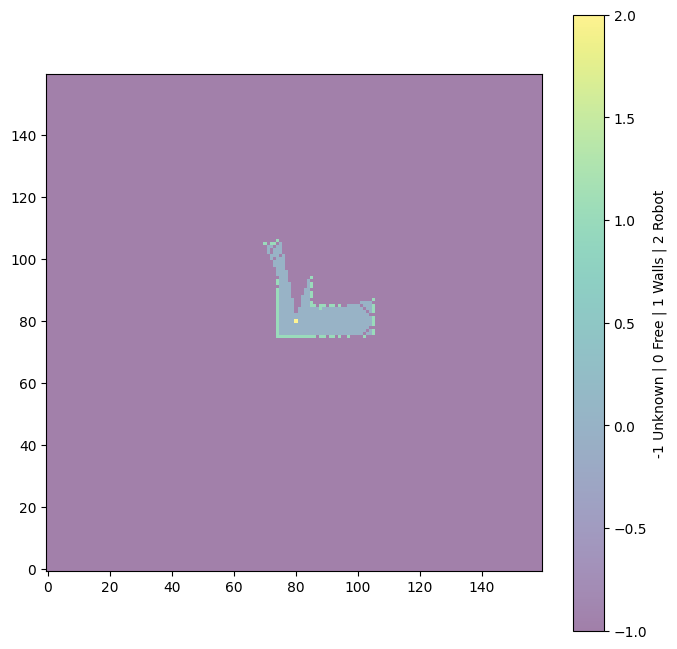

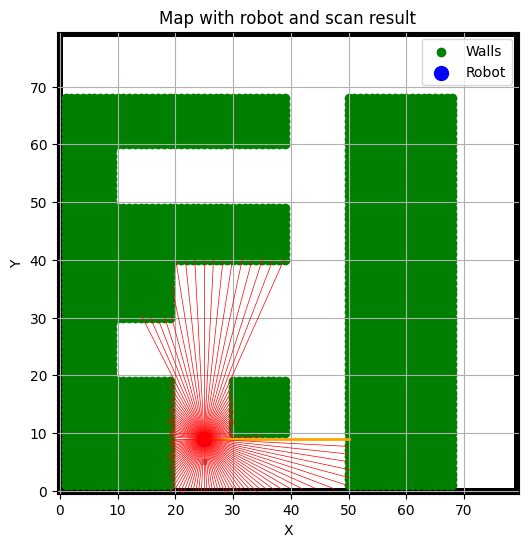

actual_diff_x_accum=0.0
actual_diff_y_accum=4.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=1.5903434947008277
estimated_diff_y_accum=-0.1495278016476056
estimated_diff_theta_accum=0.36143598048295866

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=750
i=1 Grid and Map area diff: 76.71%


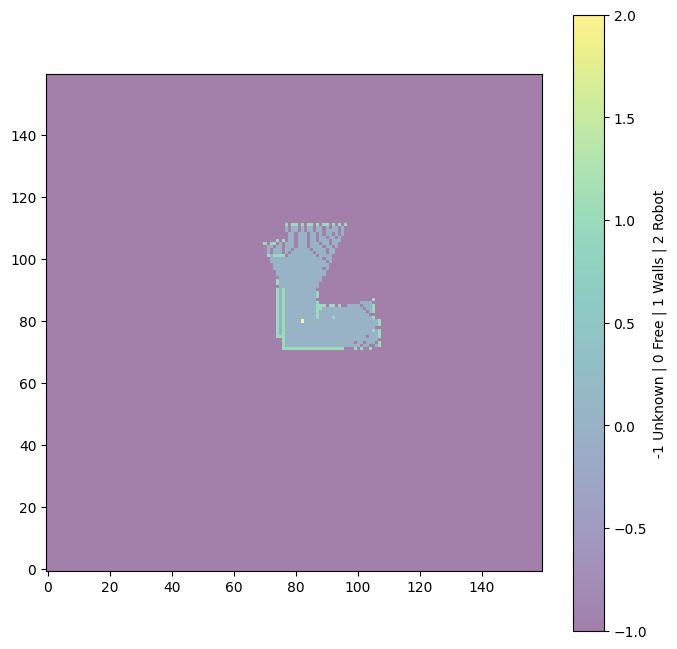

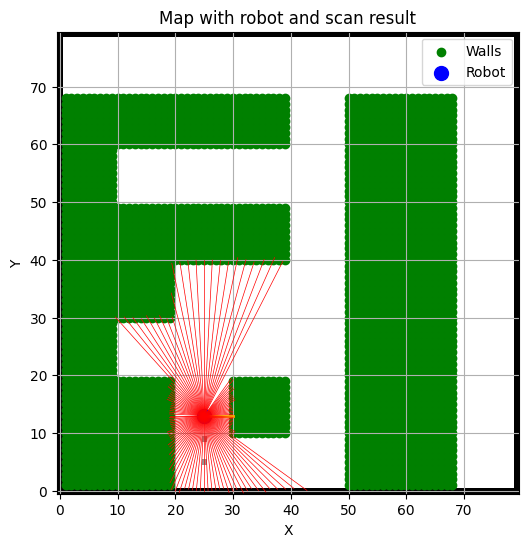

actual_diff_x_accum=0.0
actual_diff_y_accum=8.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=1.4792898150971243
estimated_diff_y_accum=3.9224136190659054
estimated_diff_theta_accum=0.32767049046038477

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=820
i=2 Grid and Map area diff: 74.53%


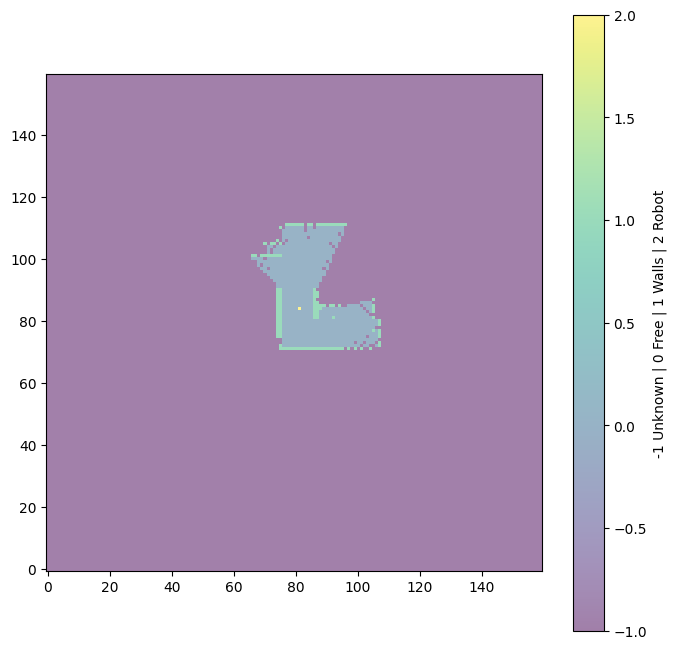

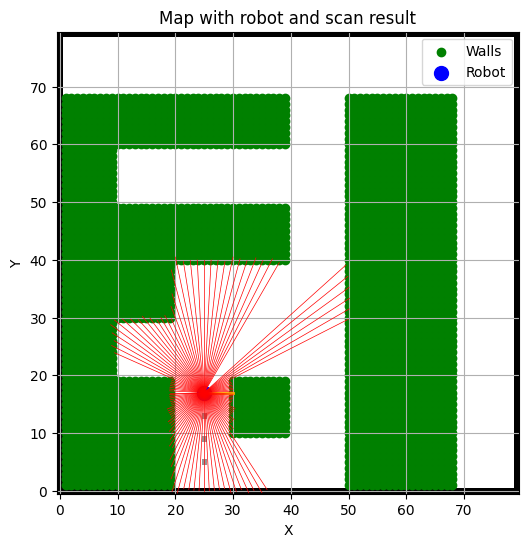

actual_diff_x_accum=0.0
actual_diff_y_accum=12.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=1.398843355651401
estimated_diff_y_accum=8.066491663819491
estimated_diff_theta_accum=0.4517662299373446

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=959
i=3 Grid and Map area diff: 70.22%


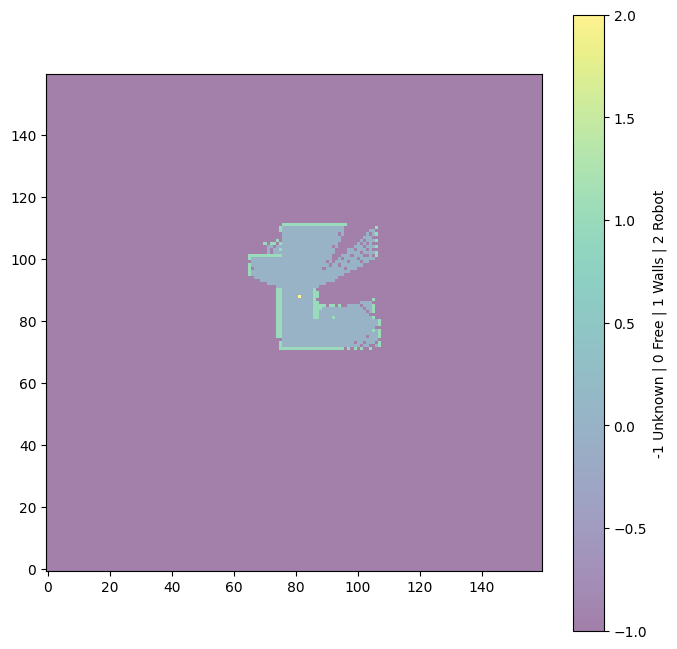

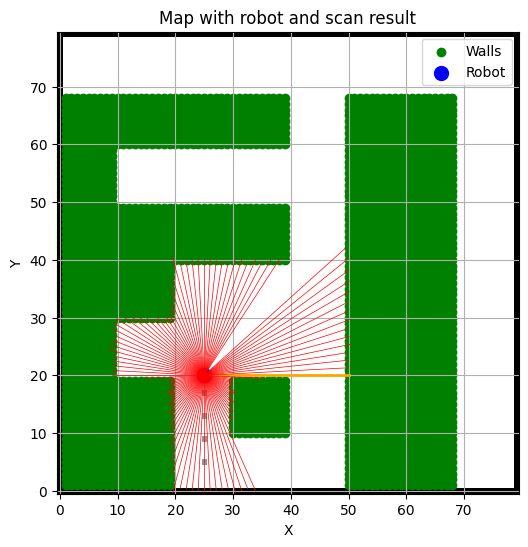

actual_diff_x_accum=0.0
actual_diff_y_accum=15.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=1.5774169525354216
estimated_diff_y_accum=11.44450943815712
estimated_diff_theta_accum=0.4964913171060781

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1099
i=4 Grid and Map area diff: 65.87%


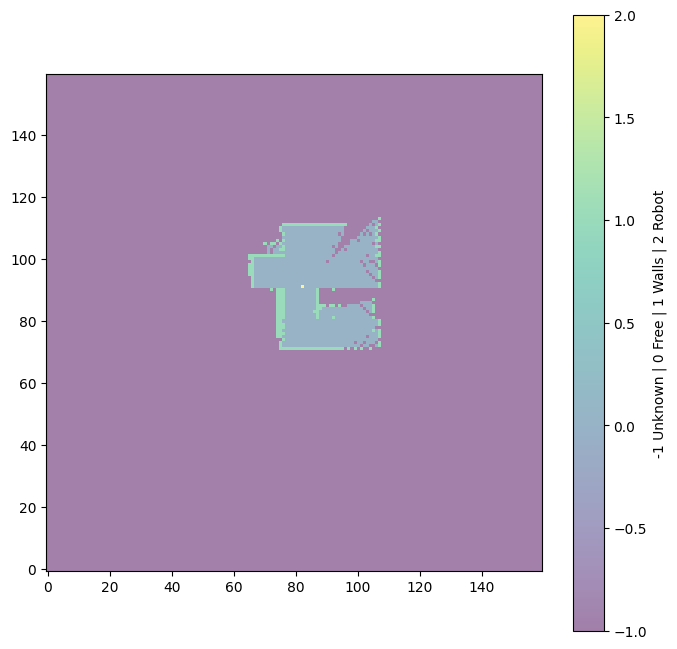

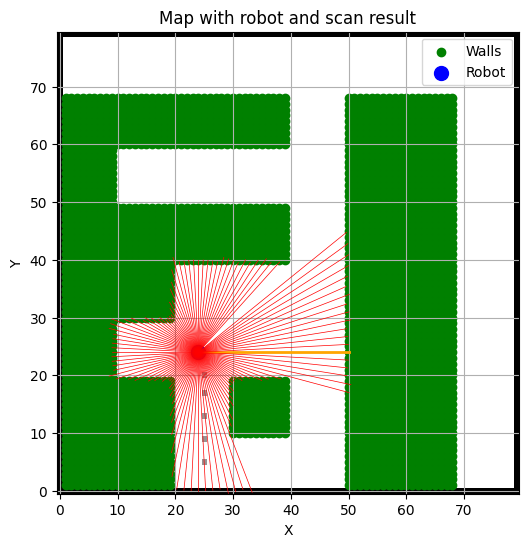

actual_diff_x_accum=-1.0
actual_diff_y_accum=19.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=0.5024458302898838
estimated_diff_y_accum=15.555203502035251
estimated_diff_theta_accum=0.49201917742430035

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1163
i=5 Grid and Map area diff: 63.88%


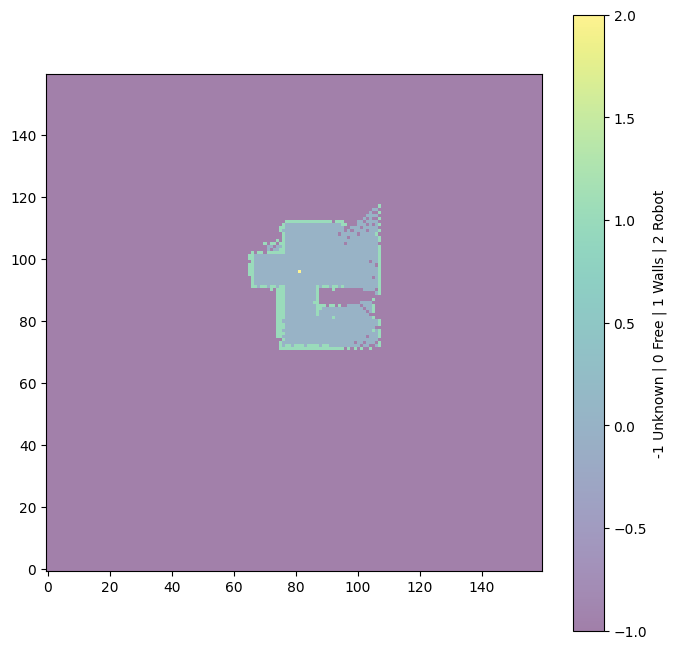

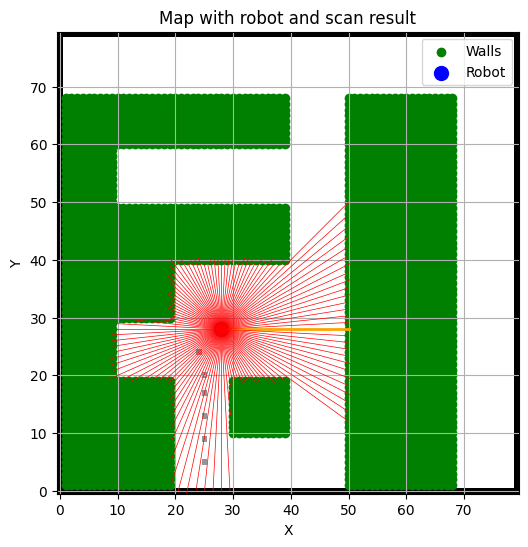

actual_diff_x_accum=3.0
actual_diff_y_accum=23.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=4.600966232106255
estimated_diff_y_accum=19.676058829503624
estimated_diff_theta_accum=0.49201917742430035

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1222
i=6 Grid and Map area diff: 62.05%


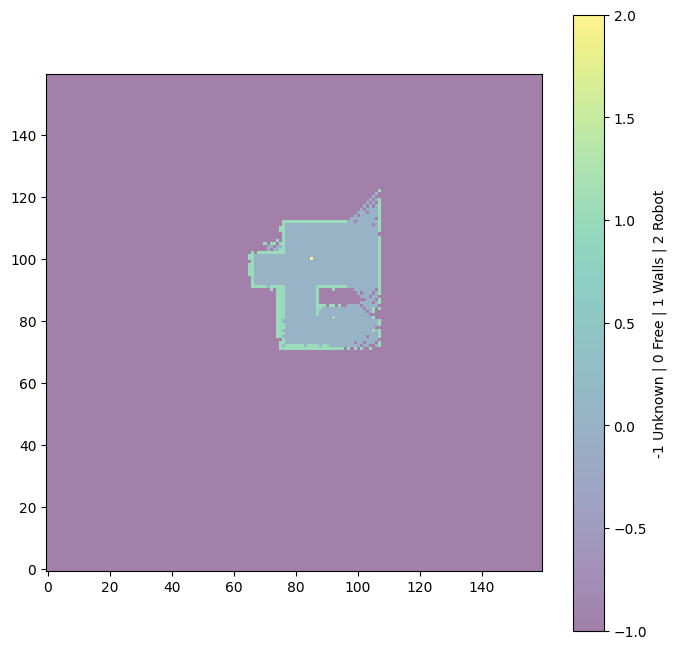

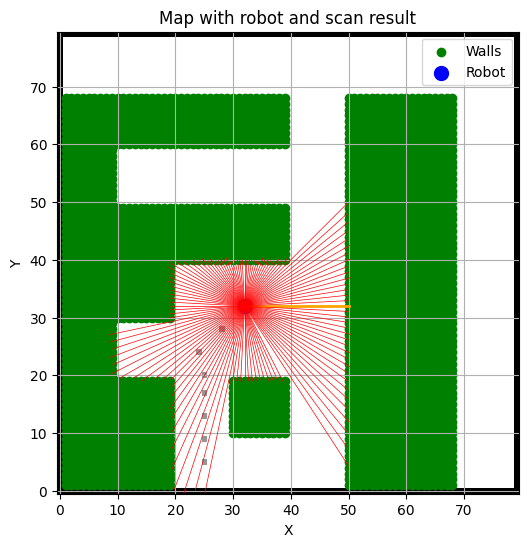

actual_diff_x_accum=7.0
actual_diff_y_accum=27.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=8.672090846653472
estimated_diff_y_accum=23.915468818426962
estimated_diff_theta_accum=0.5134671991143032

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1250
i=7 Grid and Map area diff: 61.18%


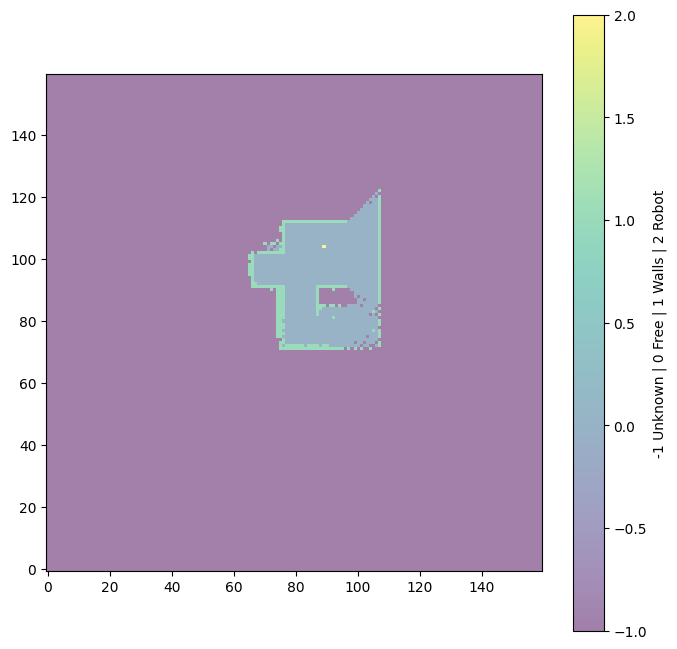

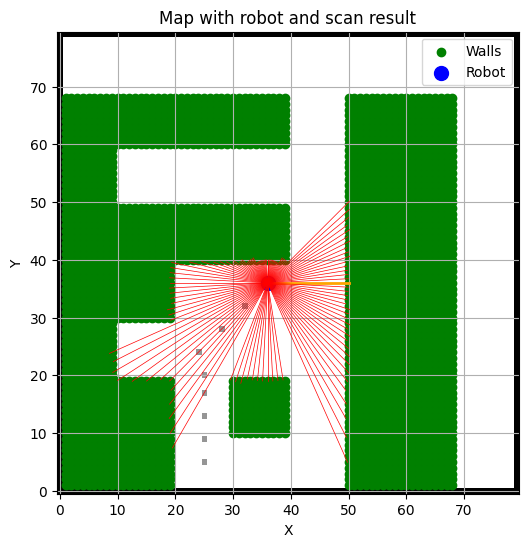

actual_diff_x_accum=11.0
actual_diff_y_accum=31.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=12.638518653474973
estimated_diff_y_accum=27.96065143058678
estimated_diff_theta_accum=0.5179393387960809

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1254
i=8 Grid and Map area diff: 61.06%


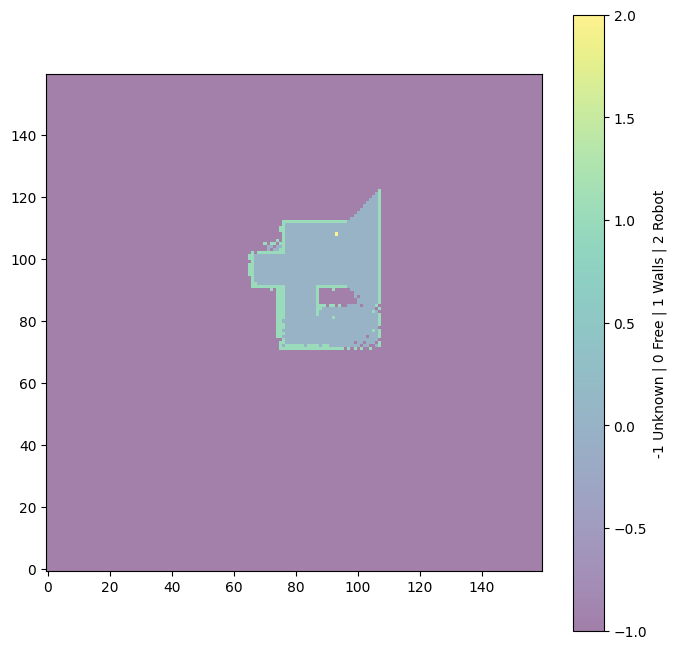

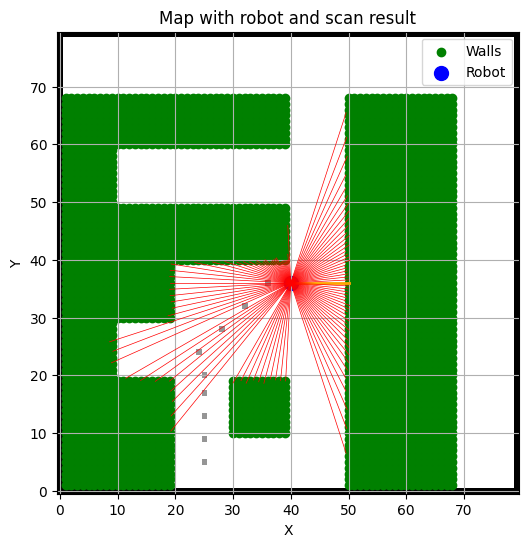

actual_diff_x_accum=15.0
actual_diff_y_accum=31.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=16.80653683302409
estimated_diff_y_accum=26.79960495337335
estimated_diff_theta_accum=0.4710308805855804

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1315
i=9 Grid and Map area diff: 59.16%


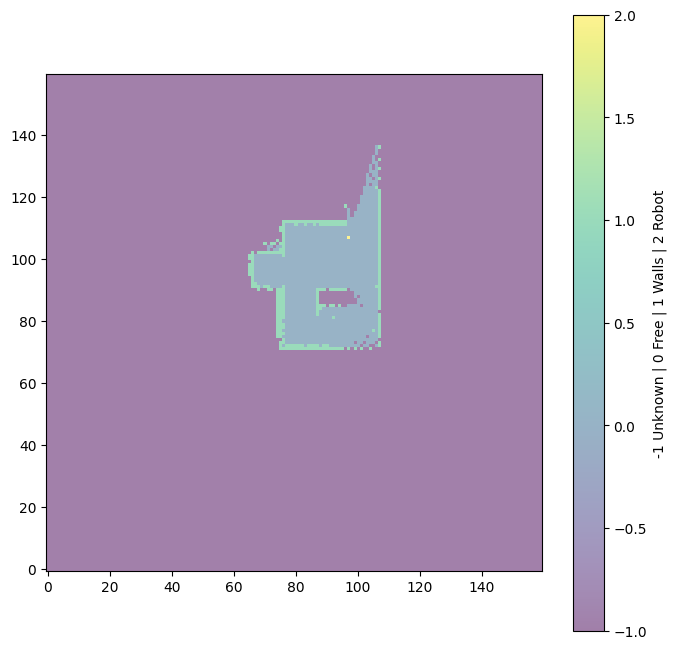

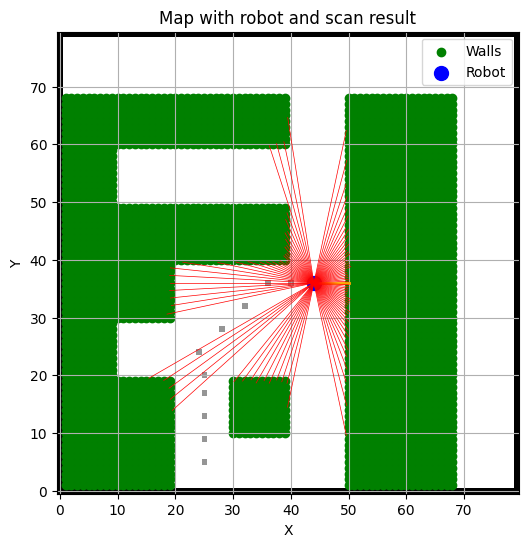

actual_diff_x_accum=19.0
actual_diff_y_accum=31.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=21.228057165075306
estimated_diff_y_accum=25.975836365610505
estimated_diff_theta_accum=0.36188959786814207

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1380
i=10 Grid and Map area diff: 57.14%


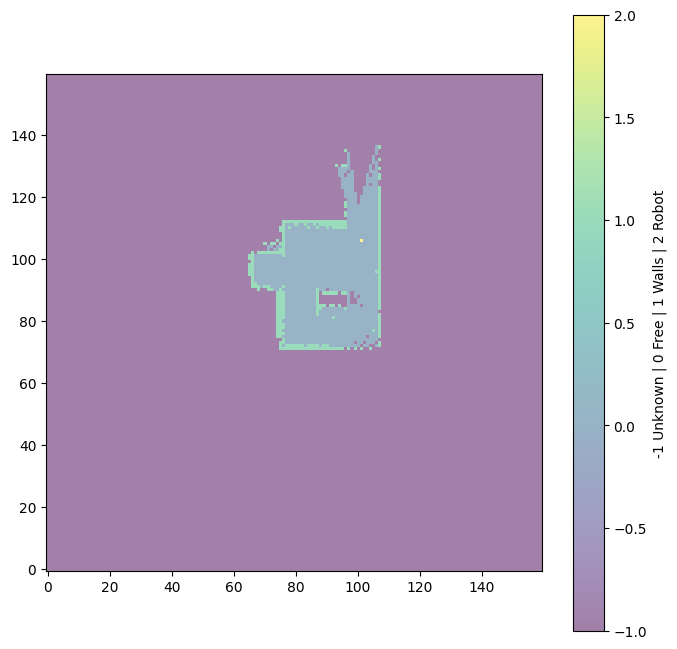

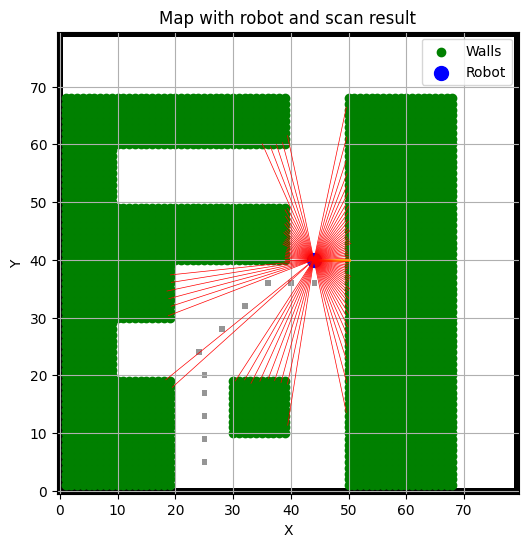

actual_diff_x_accum=19.0
actual_diff_y_accum=35.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=21.185949805560433
estimated_diff_y_accum=29.75586733351998
estimated_diff_theta_accum=0.35556503200682915

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1393
i=11 Grid and Map area diff: 56.74%


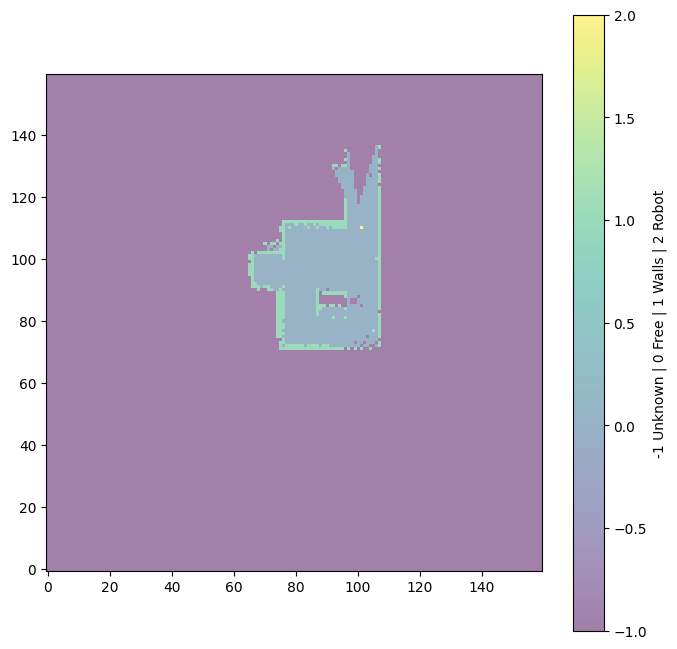

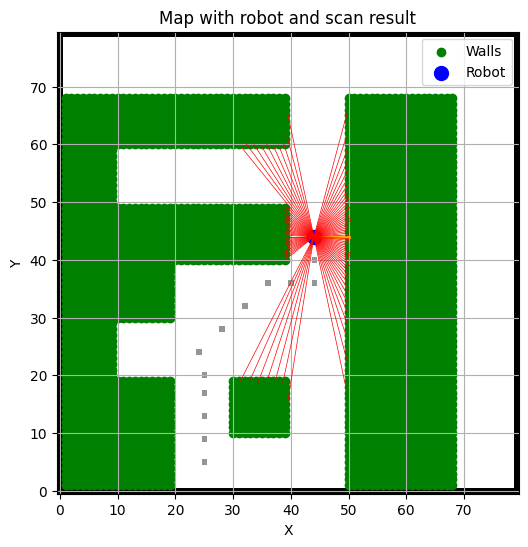

actual_diff_x_accum=19.0
actual_diff_y_accum=39.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=21.230617210193728
estimated_diff_y_accum=33.641499299021646
estimated_diff_theta_accum=0.3421485235167312

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1426
i=12 Grid and Map area diff: 55.71%


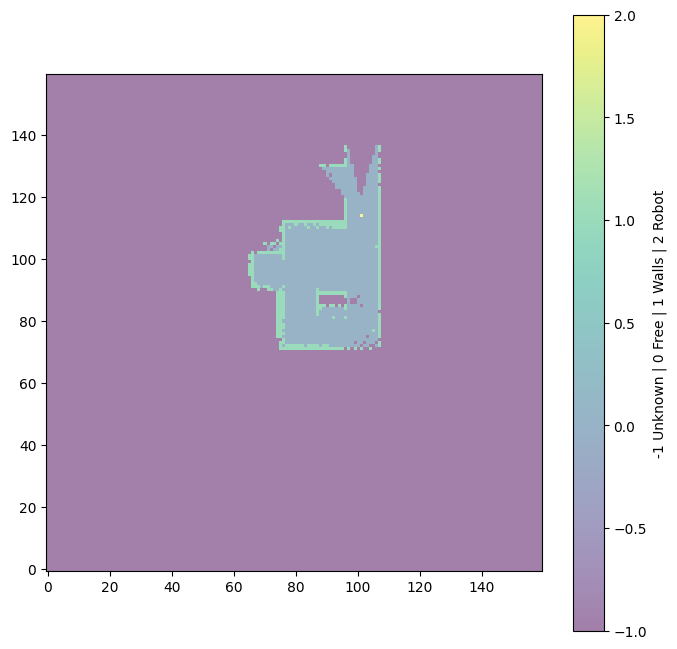

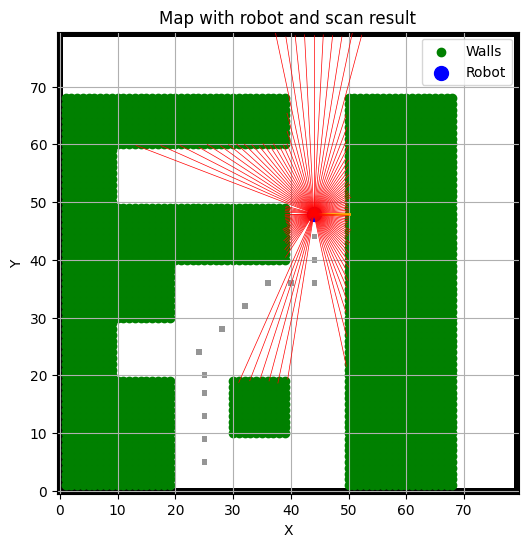

actual_diff_x_accum=19.0
actual_diff_y_accum=43.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=21.9900536393792
estimated_diff_y_accum=33.82179751489791
estimated_diff_theta_accum=0.1808526607766885

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1736
i=13 Grid and Map area diff: 46.09%


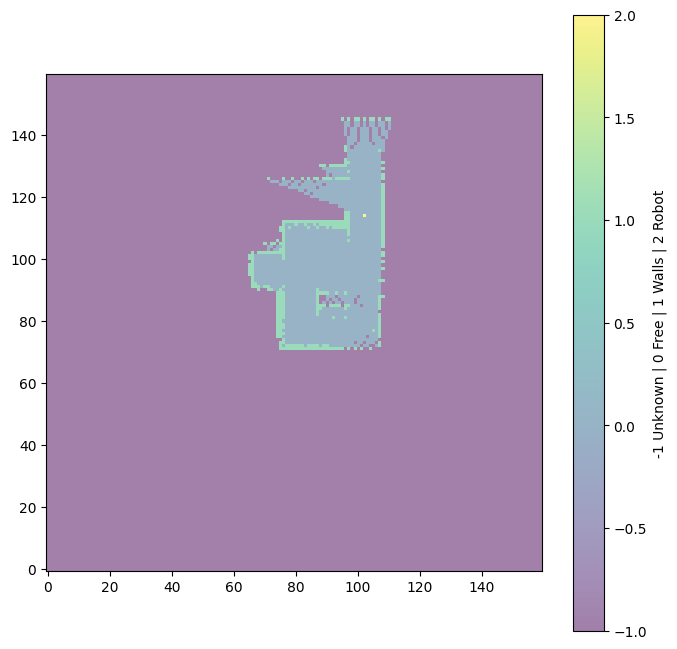

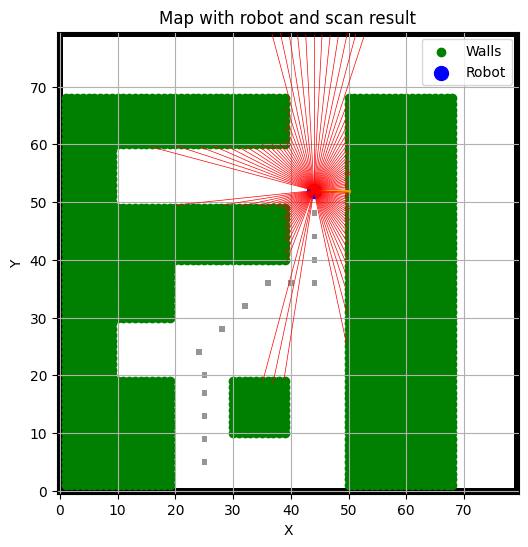

actual_diff_x_accum=19.0
actual_diff_y_accum=47.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=22.118441992981424
estimated_diff_y_accum=37.625277152180566
estimated_diff_theta_accum=0.14343390393163613

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1797
i=14 Grid and Map area diff: 44.19%


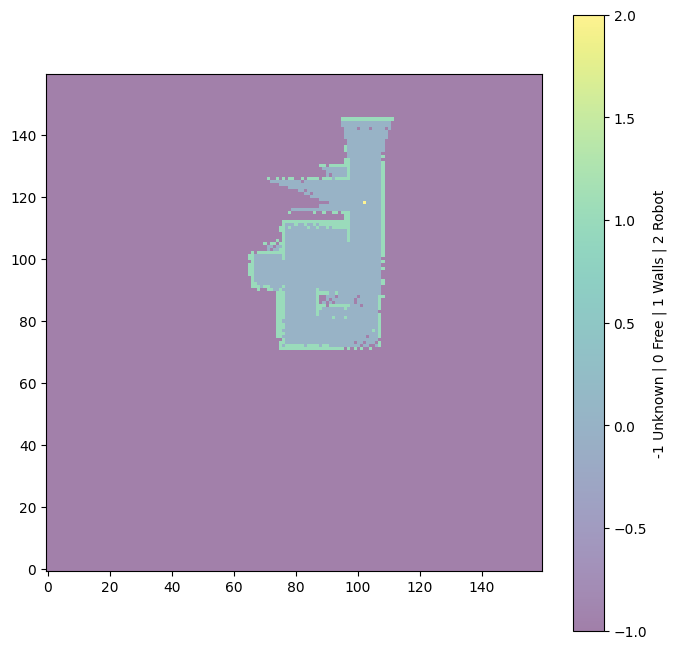

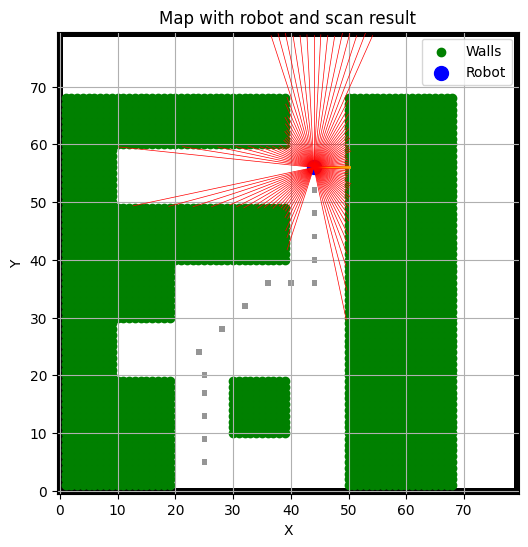

actual_diff_x_accum=19.0
actual_diff_y_accum=51.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=22.566654383194102
estimated_diff_y_accum=42.25057907447617
estimated_diff_theta_accum=0.16441046547732052

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1867
i=15 Grid and Map area diff: 42.02%


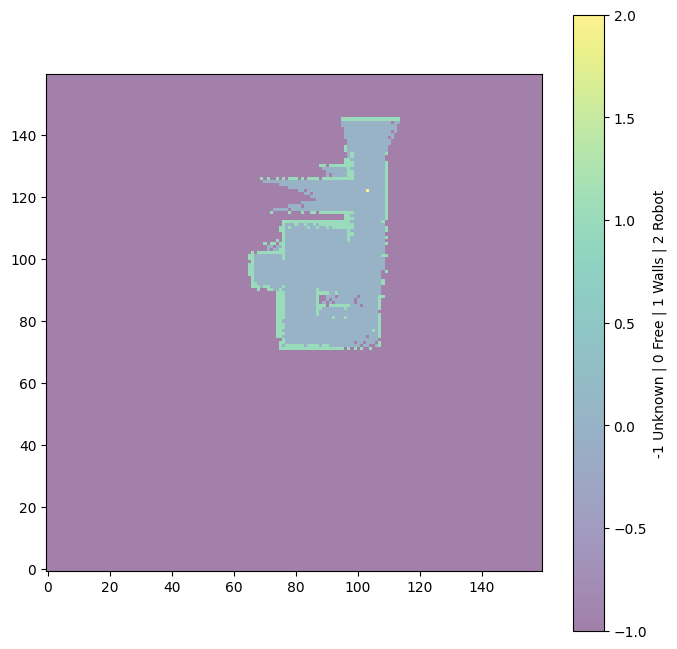

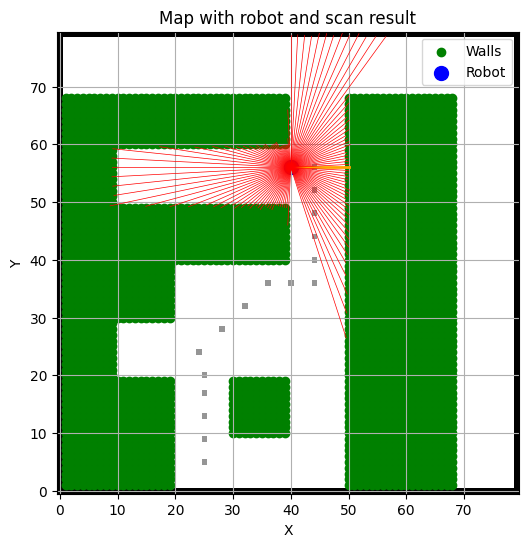

actual_diff_x_accum=15.0
actual_diff_y_accum=51.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=18.881640773782966
estimated_diff_y_accum=42.647905852127664
estimated_diff_theta_accum=0.19339423346194323

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=1980
i=16 Grid and Map area diff: 38.51%


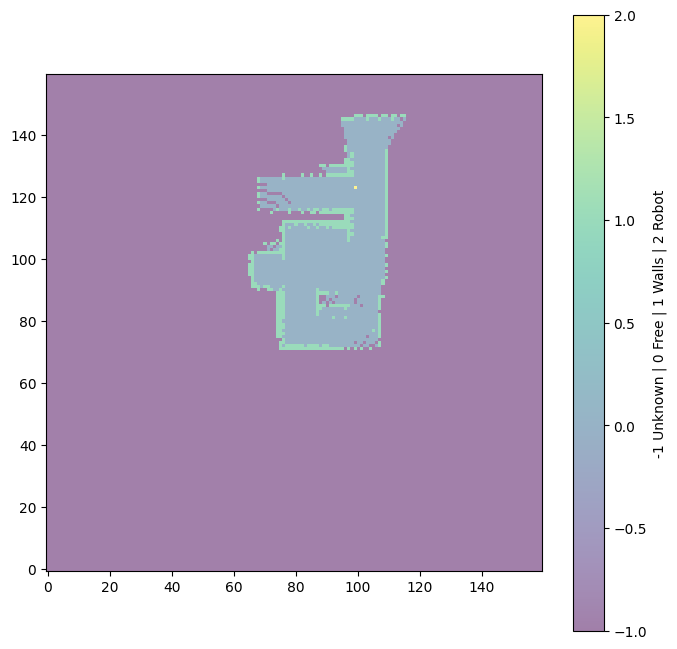

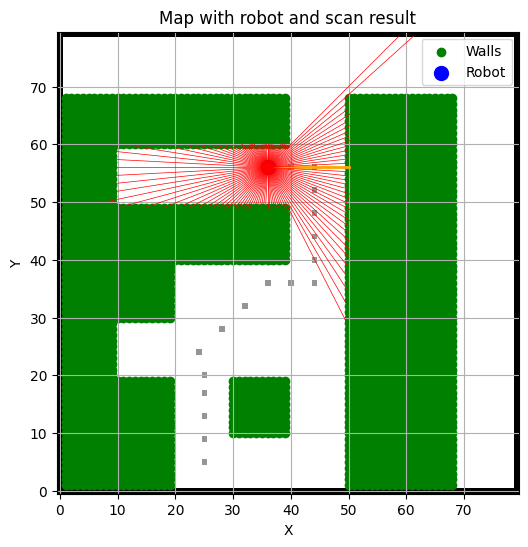

actual_diff_x_accum=11.0
actual_diff_y_accum=51.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=14.755214068847975
estimated_diff_y_accum=42.7565558260265
estimated_diff_theta_accum=0.21236818403946783

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=2011
i=17 Grid and Map area diff: 37.55%


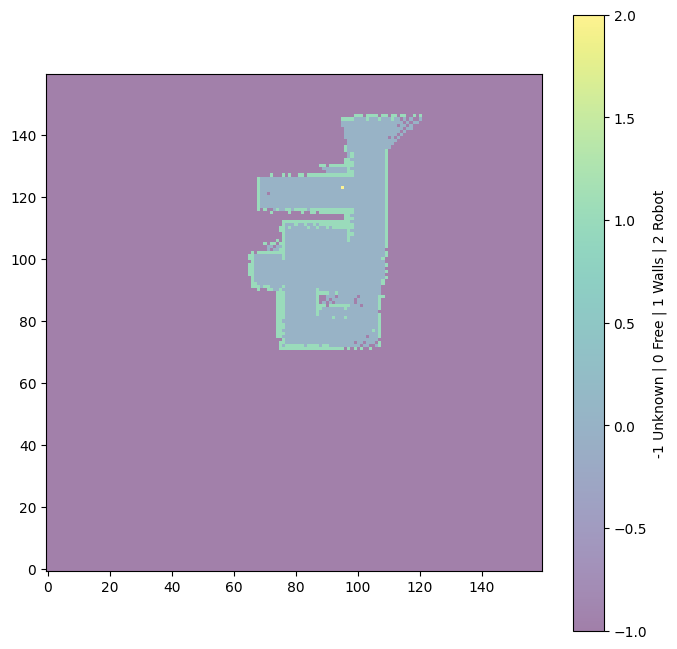

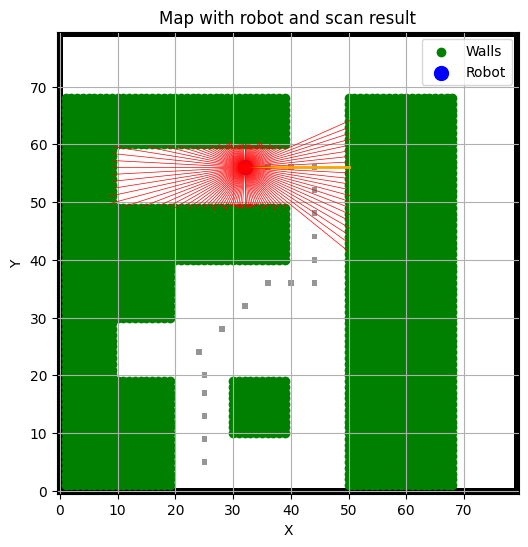

actual_diff_x_accum=7.0
actual_diff_y_accum=51.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=10.773126971036932
estimated_diff_y_accum=42.779858400337304
estimated_diff_theta_accum=0.2213124857639795

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=2008
i=18 Grid and Map area diff: 37.64%


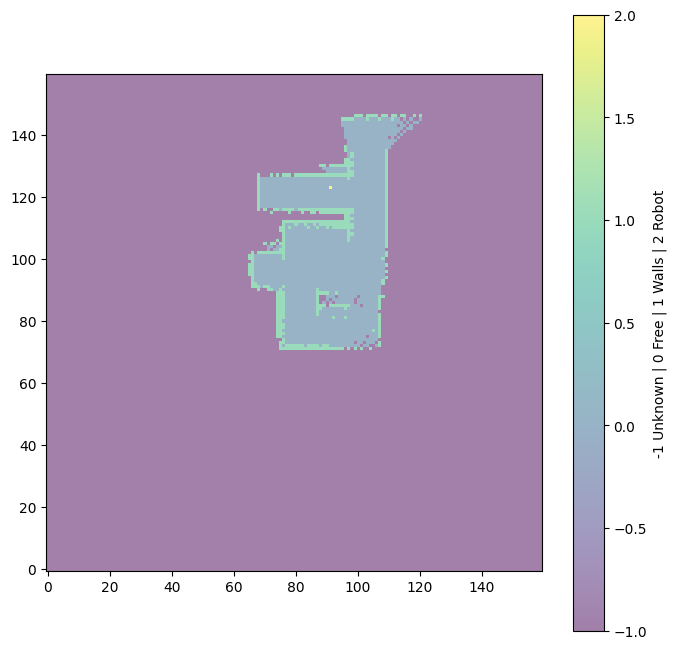

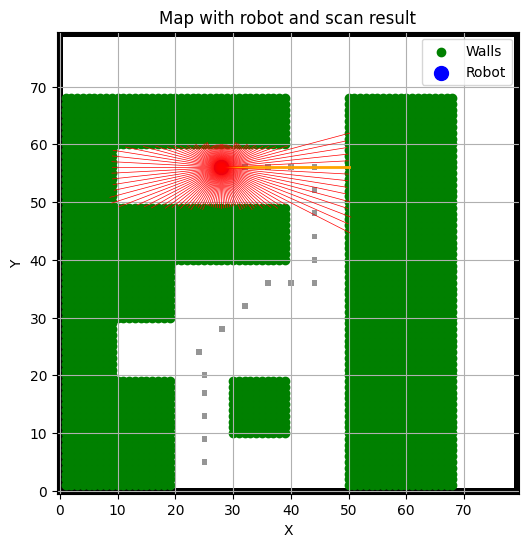

actual_diff_x_accum=3.0
actual_diff_y_accum=51.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=6.805935838186914
estimated_diff_y_accum=42.795703208440145
estimated_diff_theta_accum=0.22578462544575725

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=2007
i=19 Grid and Map area diff: 37.67%


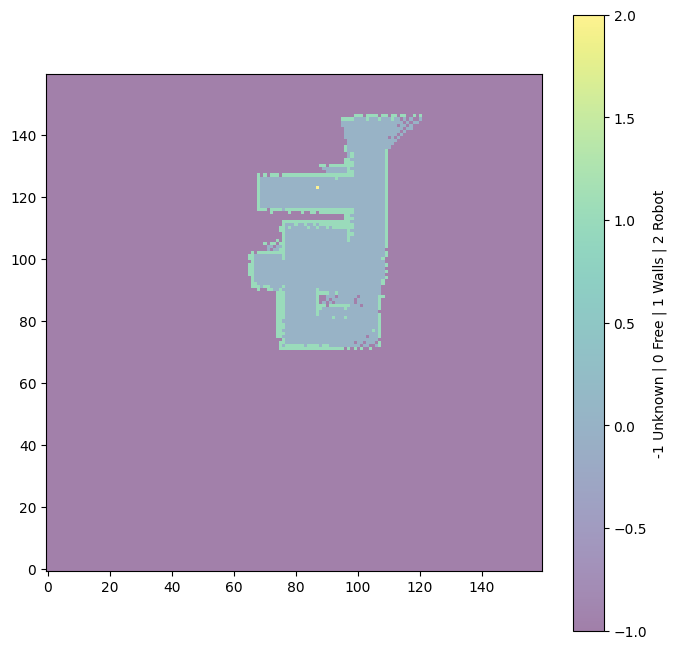

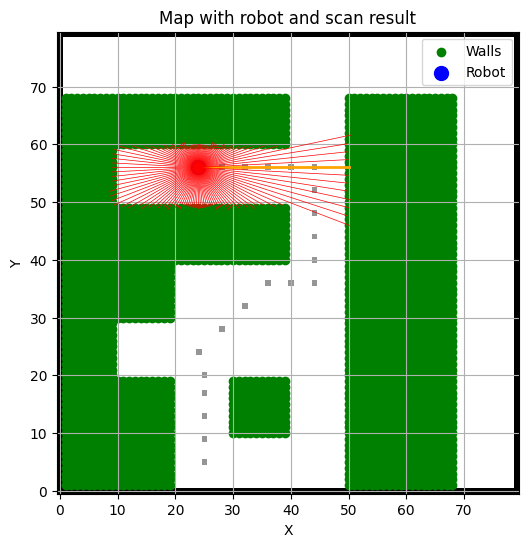

actual_diff_x_accum=-1.0
actual_diff_y_accum=51.0
actual_diff_theta_accum=0.0

estimated_diff_x_accum=2.925271010874141
estimated_diff_y_accum=42.76967142443913
estimated_diff_theta_accum=0.22578462544575725

Actual room area: total_tiles=6400 free_tiles=3220
Occupancy grid map area: free_tiles=2007
i=20 Grid and Map area diff: 37.67%


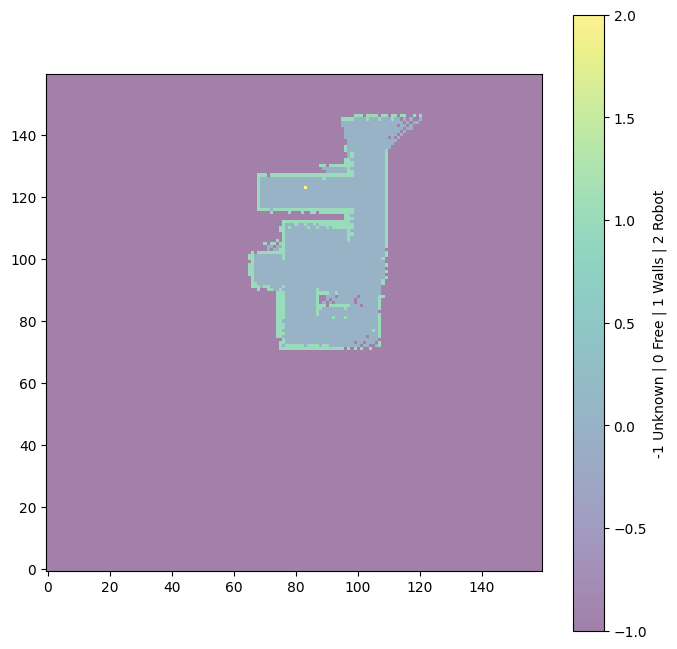

In [10]:
start_experiment(room_test_2)